<a href="https://colab.research.google.com/github/FrancoCalcia/MDD-TP2/blob/main/TP2_MDD_Avecilla_Calcia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico N° 2 - Minería de Datos

**Año:** 2024  
**Materia:** Minería de Datos  
**Integrantes:**
*   Avecilla Tomás (A-4239/9)
*   Calcia Franco (C-7363/2)



En este segundo trabajo práctico, aplicamos técnicas de minería de datos a problemas en dos conjuntos de datos: uno enfocado en el comportamiento financiero de empresas y otro en un juego de cartas. Utilizamos árboles de decisión para la predicción del atributo *Profit* y del tipo de Pokémon, en ambos contextos, ajustando parámetros específicos y evaluando los resultados a través de distintas métricas de error y precisión. Además, implementamos modelos de Bayes Ingenuo y k-NN para comparar el rendimiento en el problema de clasificación.

# Preparación del entorno de trabajo

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

In [ ]:
!gdown "15v2zJbE7aiQfSPif5B0qlO1mwmOLtfJZ" --output "1000_Companies.csv"
!gdown "1Pfh2QLdMTJeNZhkQGfW718NIyf4KS-ou" --output "PokemonDBCart.csv"

Downloading...
From: https://drive.google.com/uc?id=15v2zJbE7aiQfSPif5B0qlO1mwmOLtfJZ
To: /content/1000_Companies.csv
100% 52.2k/52.2k [00:00<00:00, 66.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pfh2QLdMTJeNZhkQGfW718NIyf4KS-ou
To: /content/PokemonDBCart.csv
100% 18.9k/18.9k [00:00<00:00, 34.8MB/s]


In [ ]:
df_companias = pd.read_csv('1000_Companies.csv')
df_pokemon = pd.read_csv('PokemonDBCart.csv')

# **Dataset de Companias**

## Análisis Descriptivo

In [ ]:
df_companias.head()

RyD_Spend  Administration  MarketingSpend       State     Profit
0  165349.20       136897.80       471784.10    New York  192261.83
1  162597.70       151377.59       443898.53  California  191792.06
2  153441.51       101145.55       407934.54     Florida  191050.39
3  144372.41       118671.85       383199.62    New York  182901.99
4  142107.34        91391.77       366168.42     Florida  166187.94

In [ ]:
df_companias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


El conjunto de datos consta de 1000 entradas y 5 columnas:

- **RyD_Spend**: Gasto en I+D (float).
- **Administration**: Costos de administración (float).
- **MarketingSpend**: Costos de marketing (float).
- **State**: Estado donde está ubicada la empresa (object).
- **Profit**: Beneficio de la empresa (float), que será nuestra variable objetivo para la regresión.


In [ ]:
# Resumen de estadísticas descriptivas
stats = df_companias.describe().T
stats['missing_values'] = df_companias.isnull().sum()
stats = stats.round(2)
stats.head(35)

count       mean       std       min        25%        50%  \
RyD_Spend       1000.0   81668.93  46537.57      0.00   43084.50   79936.00   
Administration  1000.0  122963.90  12613.93  51283.14  116640.68  122421.61   
MarketingSpend  1000.0  226205.06  91578.39      0.00  150969.58  224517.89   
Profit          1000.0  119546.16  42888.63  14681.40   85943.20  117641.47   

                      75%        max  missing_values  
RyD_Spend       124565.50  165349.20               0  
Administration  129139.12  321652.14               0  
MarketingSpend  308189.81  471784.10               0  
Profit          155577.11  476485.43               0

Observamos que no contamos con valores nulos.

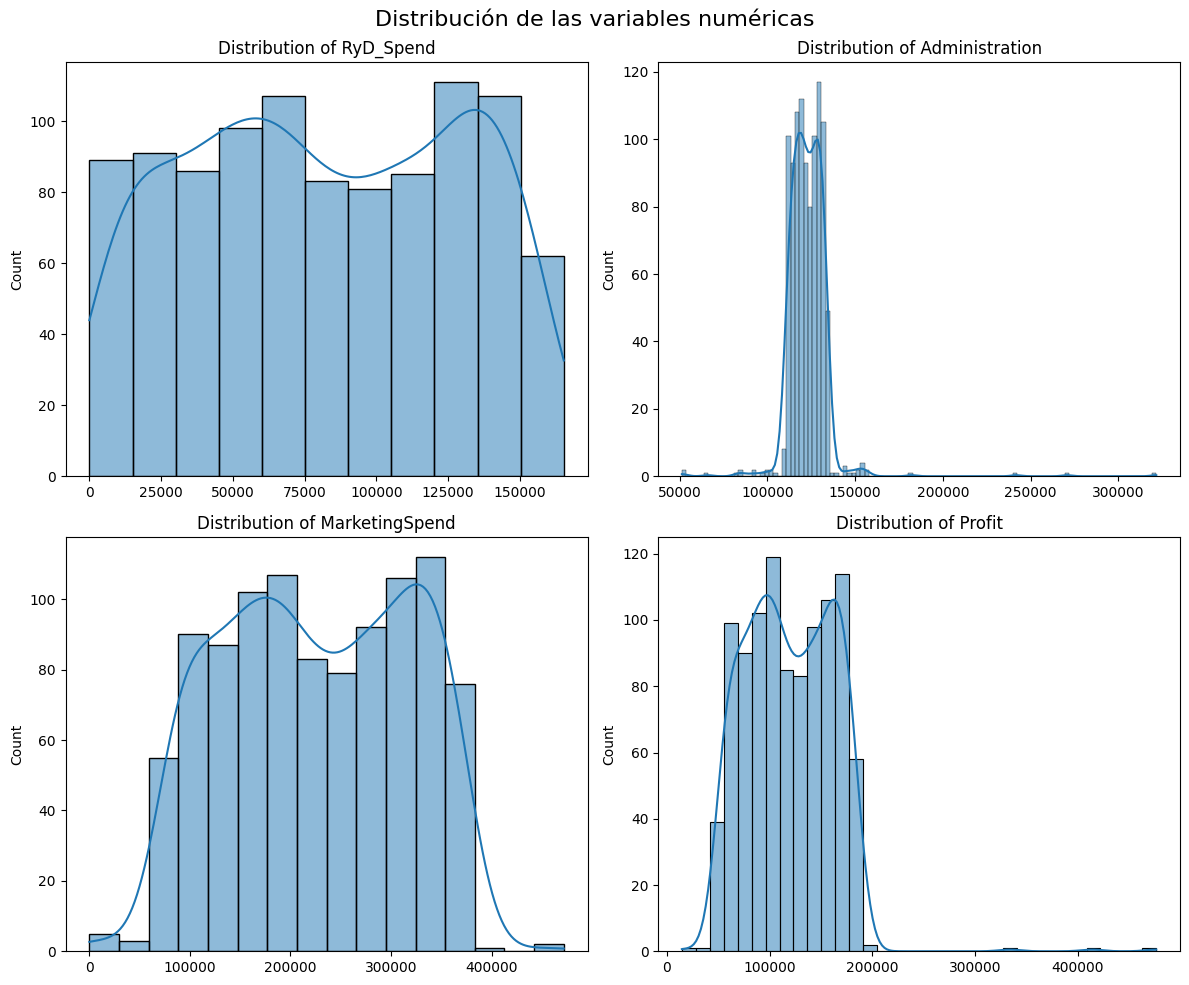

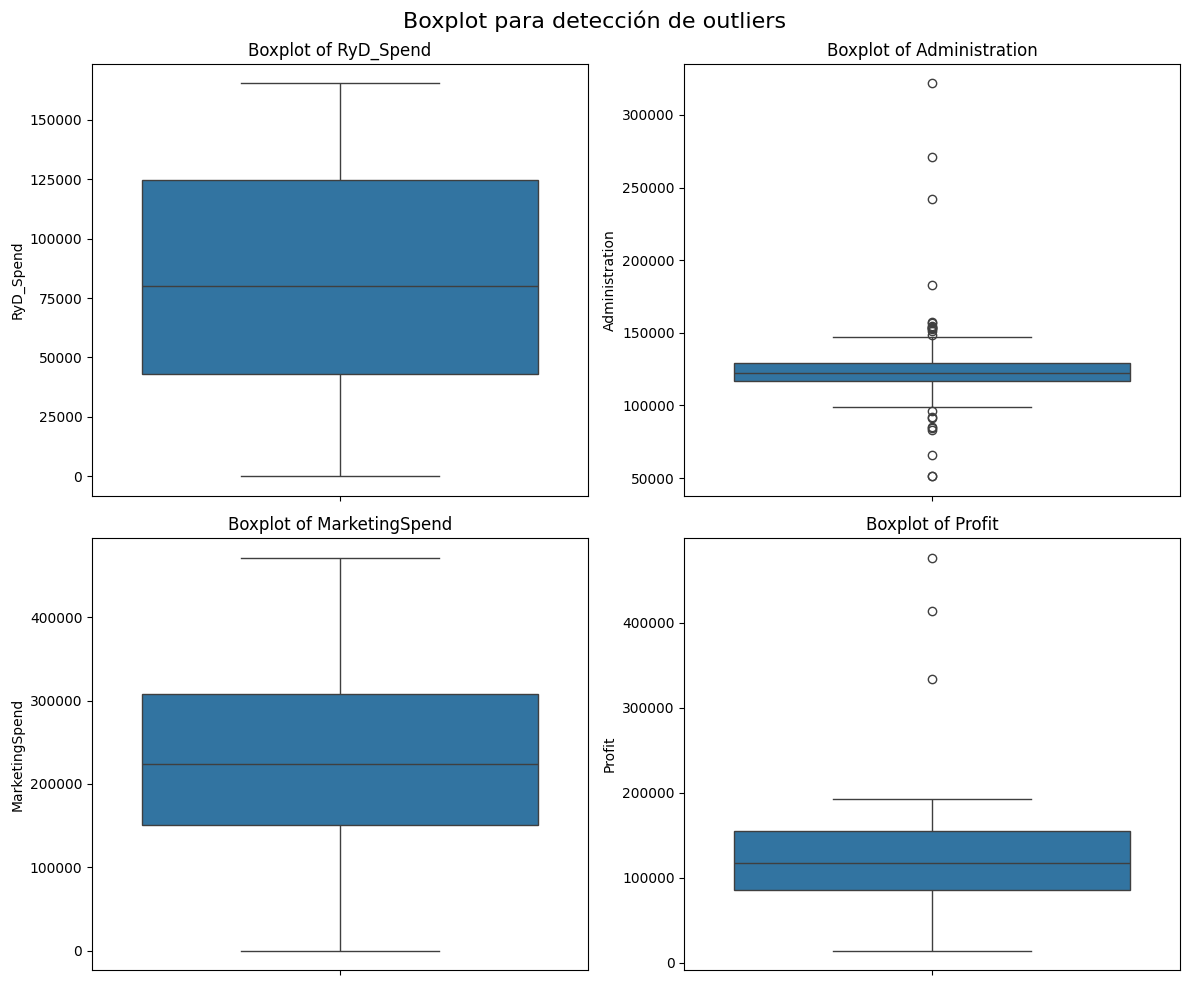

In [ ]:
# Plot histograms to visualize distributions of the numerical features
df_numeric = df_companias.select_dtypes(include=['float64'])

# Create subplots for each numeric column
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Distribución de las variables numéricas', fontsize=16)

for i, col in enumerate(df_numeric.columns):
    sns.histplot(df_companias[col], kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribution of {col}')
    axes[i//2, i%2].set_xlabel('')

plt.tight_layout()
plt.show()

# Check for outliers using box plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Boxplot para detección de outliers', fontsize=16)

for i, col in enumerate(df_numeric.columns):
    sns.boxplot(df_companias[col], ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Boxplot of {col}')
    axes[i//2, i%2].set_xlabel('')

plt.tight_layout()
plt.show()

En el gráfico de distribución de las variables numéricas, se observan los siguientes puntos:

1. **RyD_Spend**: La distribución es aproximadamente uniforme, con valores que oscilan entre 0 y 160,000. Hay variabilidad en el gasto en investigación y desarrollo, sin una tendencia clara hacia un valor específico.

2. **Administration**: La distribución es bastante concentrada en torno a los valores entre 100,000 y 150,000, mostrando una gran concentración en esa área y unos pocos valores extremos más altos y más bajos. Esto nos dice que la mayoría de los valores de esta variable están en un rango estrecho, mientras que algunos **valores atípicos** están presentes. Tiende a ser una distribución asimetrica a la derecha.

3. **MarketingSpend**: La distribución muestra varios picos, indicando posibles agrupaciones de valores en intervalos específicos. Los valores están dispersos entre 0 y 400.000 aproximadamente, por lo tanto podriamos concluir que tienen una alta variabilidad en el gasto en marketing.

4. **Profit**: La distribución de las ganancias también tiene una variabilidad significativa, con picos alrededor de los 100,000 y 200,000. Esto nos dice que la ganancia tiene algunas concentraciones de valores, aunque por lo que se observa en el boxplot, también presenta algunos valores atipicos en su extremo derecho.


## Análisis Exploratorio

Procedemos a verificar el porcentaje de los valores atipicos

In [ ]:
resultados_atipicos = {}

for columna in df_companias.columns:
    if df_companias[columna].dtype in ['int64', 'float64']:
        Q1 = df_companias[columna].quantile(0.25)
        Q3 = df_companias[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df_companias[columna] < limite_inferior) | (df_companias[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df_companias)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")

Columna: RyD_Spend - Porcentaje de valores atípicos: 0.00%
Columna: Administration - Porcentaje de valores atípicos: 2.20%
Columna: MarketingSpend - Porcentaje de valores atípicos: 0.00%
Columna: Profit - Porcentaje de valores atípicos: 0.30%


La variable **Administración** es la que presenta el mayor porcentaje de valores atípicos. Sin embargo, estos porcentajes son relativamente bajos en todas las columnas. Concluimos que no realizaremos ninguna limpieza, ya que no afectarían significativamente futuros trabajos, teniendo en cuenta que los árboles de decisión son robustos frente a estos valores.


Miremos la matriz de correlación.

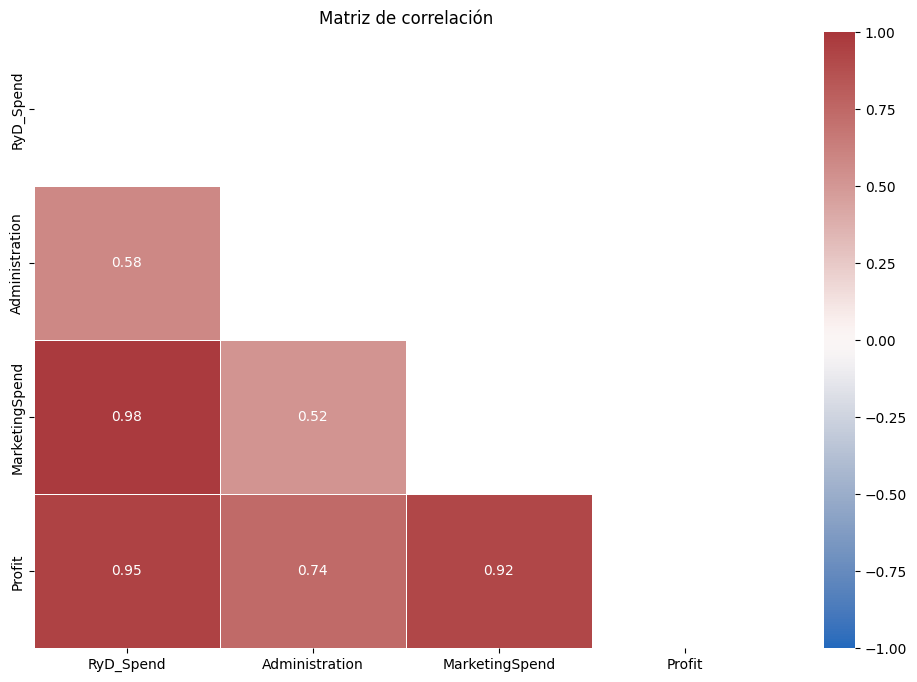

In [ ]:
# Calcular la matriz de correlación
corr_matrix = df_numeric.corr()

# Crear la máscara
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Crear el colormap
colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Graficar el heatmap de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()


Contamos con columnas con una fuerte correlación entre ellas.

Veamos que datos tenemos en nuestra columna **State**.

In [ ]:
df_companias['State'].unique()

array(['New York', 'California', 'Florida'], dtype=object)

Dado que contamos con solo 3 categorías dentro de la columna **State**, cuando dividamos el dataset y apliquemos la estandarización, utilizaremos **One-Hot Encoding** para convertir nuestra variable categórica en variables binarias. Esto permitirá que el modelo procese correctamente la información categórica.


## Train-Test

In [ ]:
# Separamos la varible target
X = df_companias.drop(columns=['Profit'])
y = df_companias['Profit']

# One-hot encode para la columna "State"
X = pd.get_dummies(X, drop_first=True)

# Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
X.head()

RyD_Spend  Administration  MarketingSpend  State_Florida  State_New York
0  165349.20       136897.80       471784.10          False            True
1  162597.70       151377.59       443898.53          False           False
2  153441.51       101145.55       407934.54           True           False
3  144372.41       118671.85       383199.62          False            True
4  142107.34        91391.77       366168.42           True           False

## Escalado

In [ ]:
# Applicamos StandardScaler
scaler = StandardScaler()

# Escalamos la division de datos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Observamos las primeras 5 filas para verificar el escalado
X_train_scaled[:5]

array([[-0.35069439,  2.60594873, -1.30276507, -0.68205679,  1.36652242],
       [-1.49764066, -0.92056162, -1.46664538, -0.68205679, -0.73178456],
       [ 1.10569001,  0.63090309,  1.08244309, -0.68205679, -0.73178456],
       [ 0.03896264, -0.00481711,  0.03794172, -0.68205679, -0.73178456],
       [ 1.26914933,  0.72831728,  1.24249662, -0.68205679,  1.36652242]])

## Árbol de decisión

In [ ]:
feature_list = list(X_train.columns)

Mean Absolute Error (MAE): 578.12
Mean Squared Error (MSE): 1426120.79
Root Mean Squared Error (RMSE): 1194.20


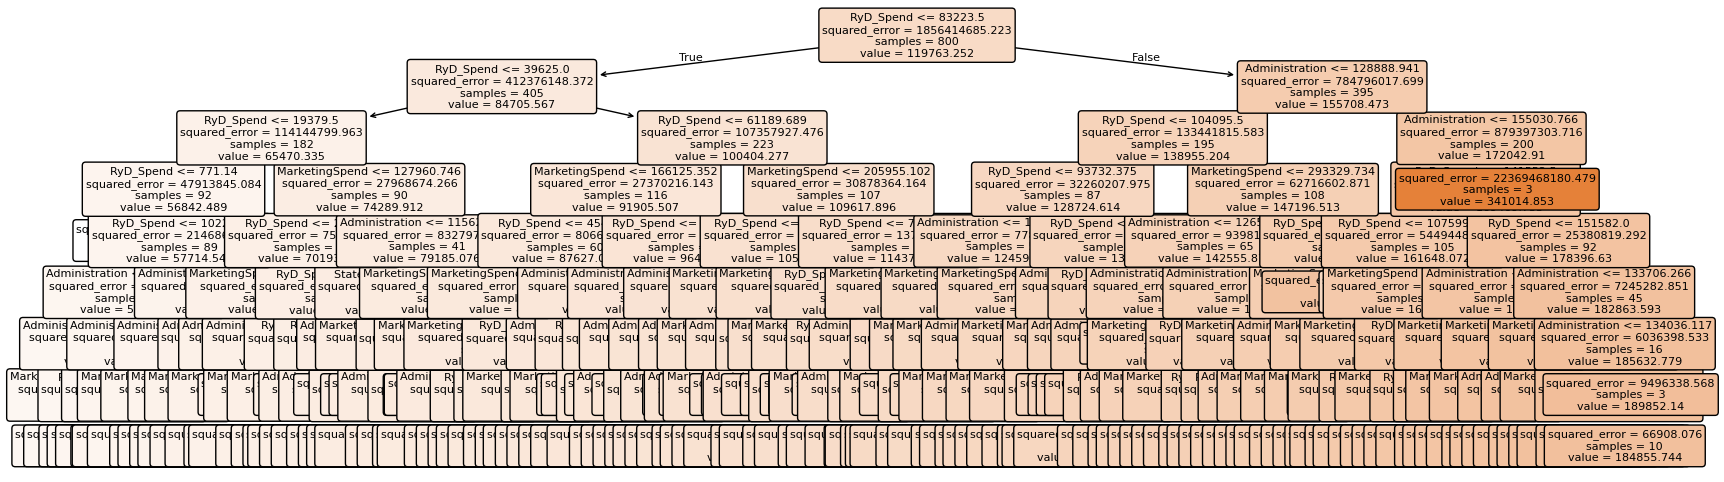

In [ ]:
# Definir el modelo
clf = tree.DecisionTreeRegressor(max_depth=8, min_samples_leaf=3, min_samples_split=2, random_state=13)

# Entrenar el modelo
regressor_tree = clf.fit(X_train, y_train)

# Hacer predicciones
predictions = clf.predict(X_test)

# Evaluar el modelo con métricas
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

# Mostrar las métricas
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


# Graficar el árbol
features = feature_list

plt.figure(figsize=(20, 6))
tree.plot_tree(regressor_tree,
               feature_names=features,
               fontsize=8,
               filled=True,
               rounded=True)
plt.show()


### Descripción del Rendimiento del Modelo:
El modelo de árbol de decisión con los hiperparámetros **`max_depth=8`**, **`min_samples_leaf=3`**, **`min_samples_split=2`**, y **`random_state=13`** fue evaluado usando tres métricas de error, obteniendo los siguientes resultados:

1. **Mean Absolute Error (MAE)**: **578.12**
   - Este valor indica que, en promedio, las predicciones del modelo se desvían del valor real en aproximadamente 578.12 unidades. Esto muestra que el modelo tiene un buen nivel de precisión.

2. **Mean Squared Error (MSE)**: **1,426,120.79**
   - Un MSE de 1,426,120.79 nos dice que el modelo mantiene un rendimiento razonable en términos de precisión, minimizando la influencia de errores grandes.

3. **Root Mean Squared Error (RMSE)**: **1,194.20**
   - El modelo tiene una desviación promedio de aproximadamente 1,194.20 unidades con respecto a los valores reales.

### Interpretación General:
Estos valores de error reflejan el desempeño del modelo al ver la relación en los datos sin caer en el sobreajuste. La configuración de **`max_depth=8`** limita la profundidad máxima del árbol, lo que ayuda a prevenir un modelo excesivamente complejo que podría ajustarse demasiado a los datos de entrenamiento. Al establecer **`min_samples_leaf=3`**, se garantiza que cada hoja tenga al menos tres muestras, lo que contribuye a una generalización mejorada. Finalmente, **`min_samples_split=2`** asegura que cada nodo se divida cuando haya al menos dos muestras, permitiendo que el árbol capte los patrones necesarios sin ser excesivamente detallado.



# **Dataset de Pokemon**

## Análisis Descriptivo

In [ ]:
df_pokemon.head()

Nombre  Ataque  Defensa  Velocidad  HP  SpAtaque  SpDefensa TipoPokemon
0   Bulbasaur      49       49         45  45        65         65      hierba
1     Ivysaur      62       63         60  60        80         80      hierba
2    Venusaur     100      123         80  80       122        120      hierba
3  Charmander      52       43         65  39        60         50       fuego
4  Charmeleon      64       58         80  58        80         65       fuego

In [ ]:
df_pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Nombre       479 non-null    object
 1   Ataque       479 non-null    int64 
 2   Defensa      479 non-null    int64 
 3   Velocidad    479 non-null    int64 
 4   HP           479 non-null    int64 
 5   SpAtaque     479 non-null    int64 
 6   SpDefensa    479 non-null    int64 
 7   TipoPokemon  479 non-null    object
dtypes: int64(6), object(2)
memory usage: 30.1+ KB


El conjunto de datos consta de 479 entradas y 8 columnas:

- **Nombre**: Nombre del Pokémon (object).
- **Ataque**: Valor de ataque (int).
- **Defensa**: Valor de defensa (int).
- **Velocidad**: Velocidad del Pokémon (int).
- **HP**: Puntos de salud (int).
- **SpAtaque**: Valor de ataque especial (int).
- **SpDefensa**: Valor de defensa especial (int).
- **TipoPokemon**: Tipo del Pokémon (object).

No se presentan valores nulos en ninguna de las columnas.

In [ ]:
stats = df_pokemon.describe().T
stats['missing_values'] = df_pokemon.isnull().sum()
stats = stats.round(2)
stats.head(35)

count   mean    std   min   25%   50%   75%    max  missing_values
Ataque     479.0  73.96  31.51   5.0  50.0  70.0  94.5  185.0               0
Defensa    479.0  70.66  29.29   5.0  50.0  65.0  85.0  230.0               0
Velocidad  479.0  66.38  29.64   5.0  45.0  64.0  85.0  180.0               0
HP         479.0  66.71  24.81   1.0  50.0  65.0  78.0  255.0               0
SpAtaque   479.0  72.78  32.25  10.0  50.0  69.0  95.0  194.0               0
SpDefensa  479.0  70.82  28.02  20.0  50.0  66.0  90.0  230.0               0

Cada columna contiene números relativamente parecidos.

Visualicemos los histogramas y boxplots.

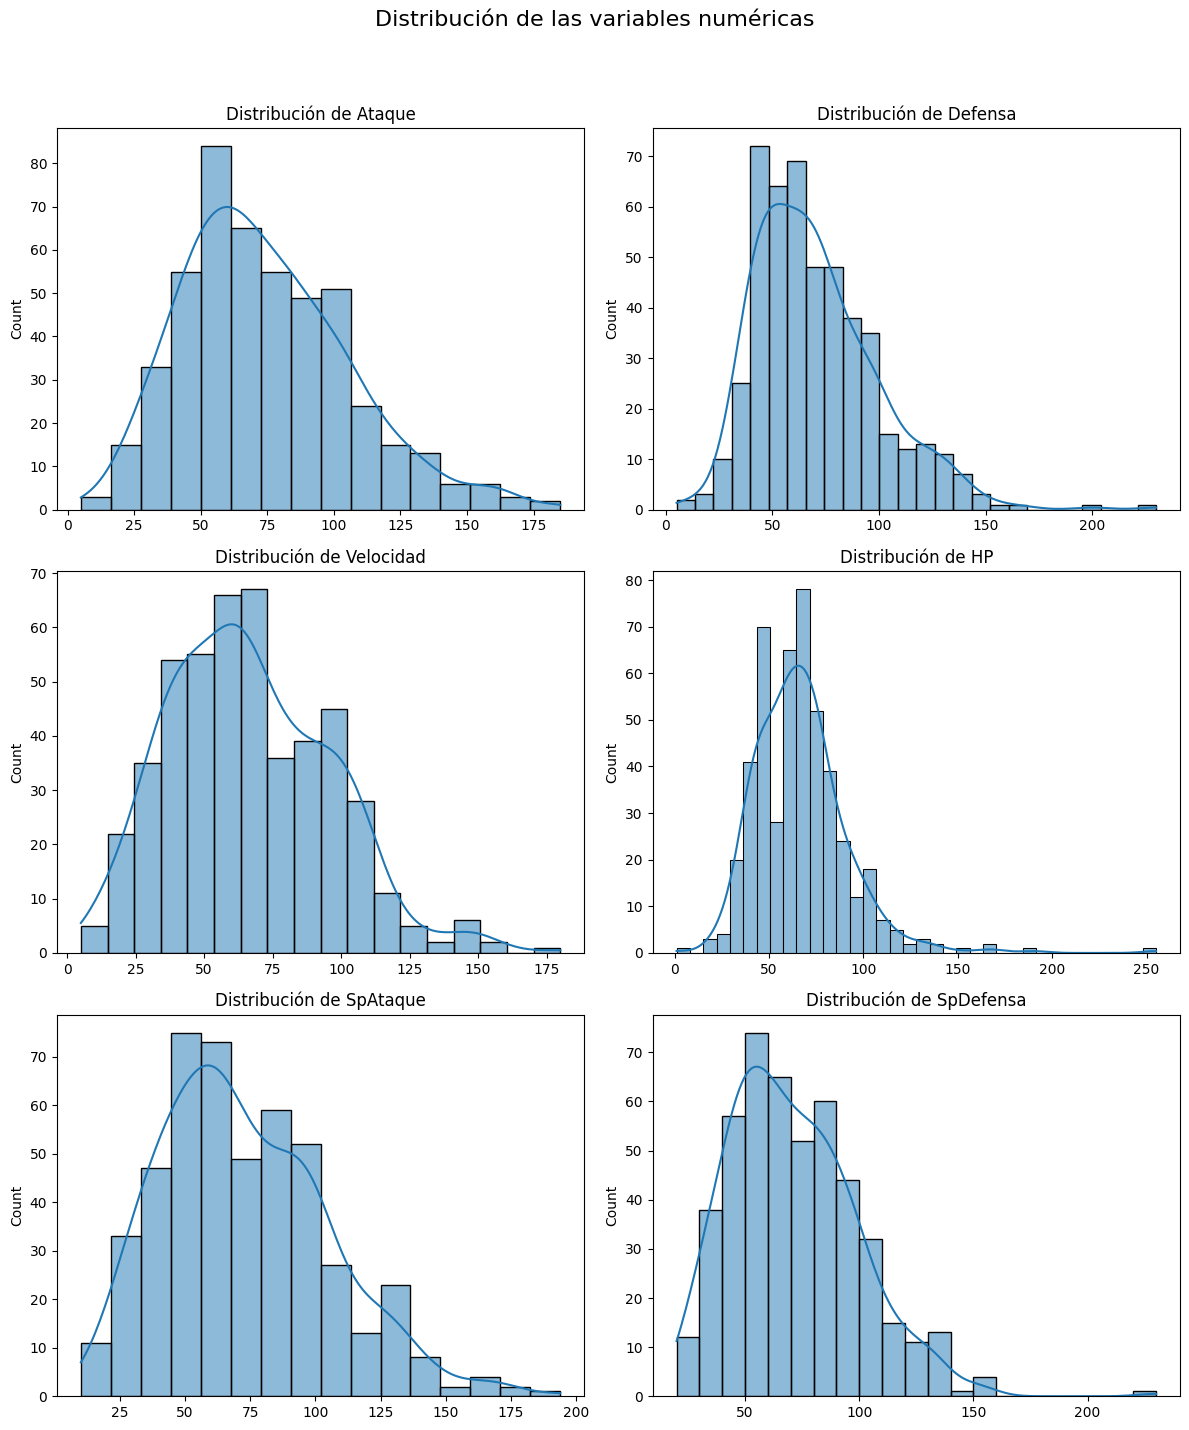

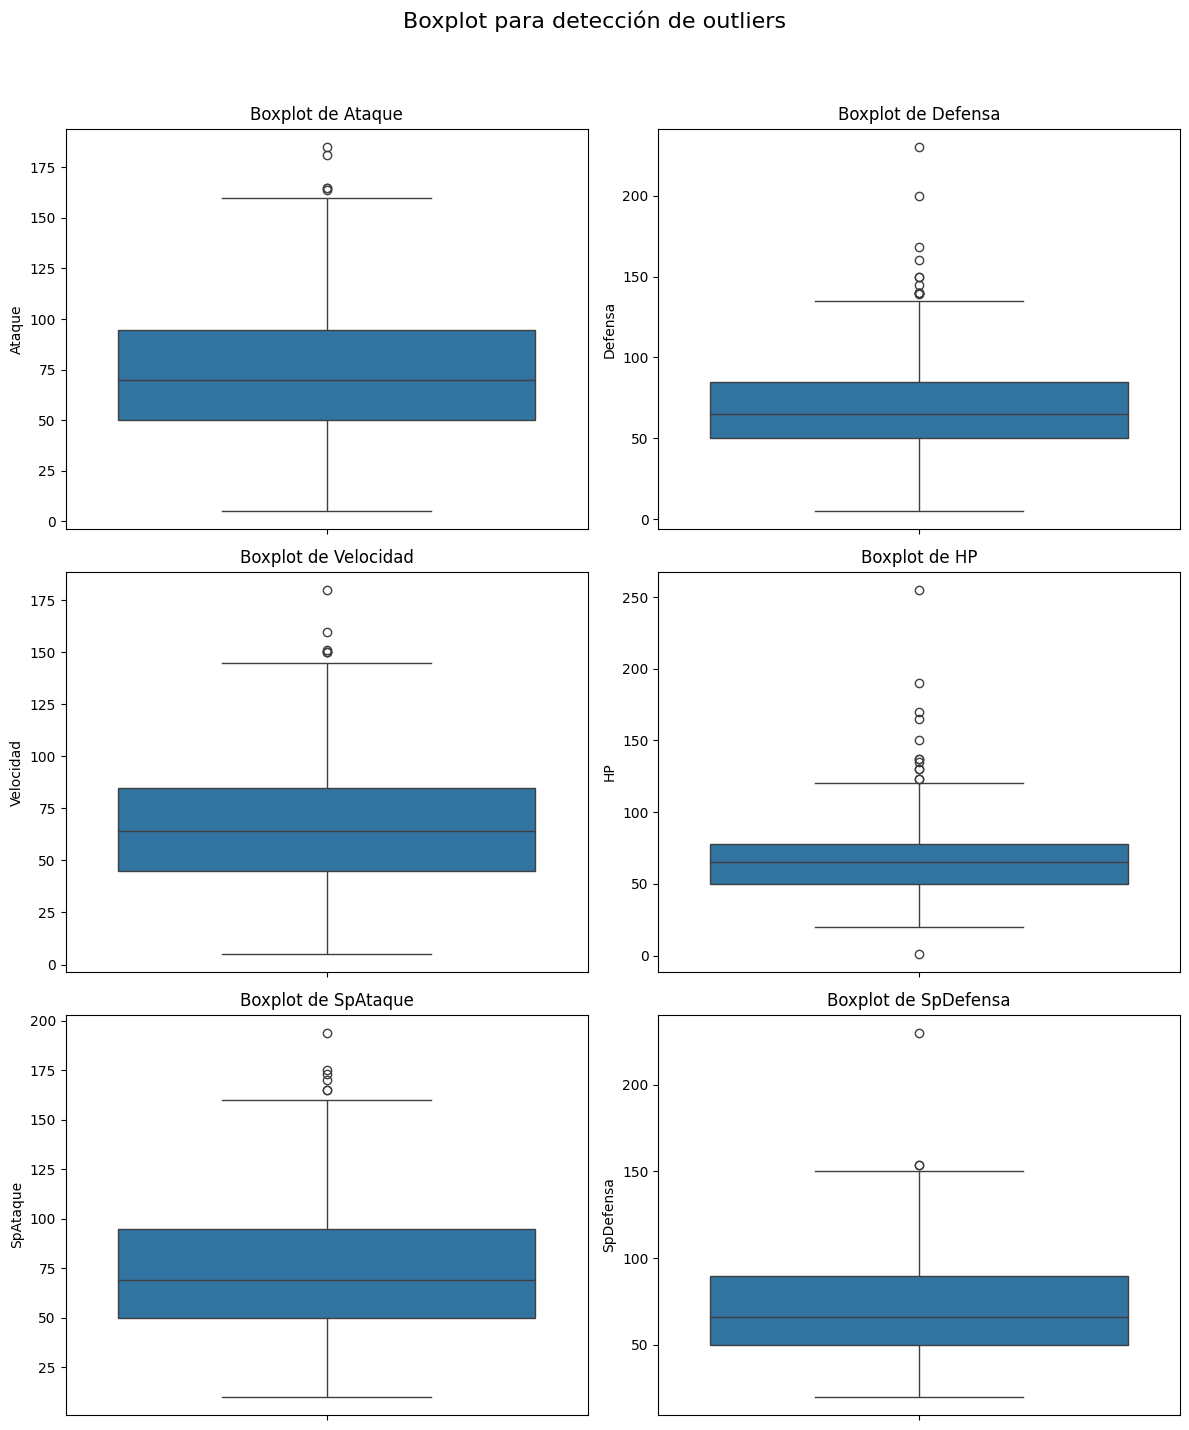

In [ ]:
df_numeric = df_pokemon.select_dtypes(include=['int64'])

# Determinar el número de filas y columnas para los subplots
num_cols = len(df_numeric.columns)
num_rows = (num_cols + 1) // 2  # Divide entre 2 y redondea hacia arriba para obtener las filas

# Crear subplots para cada columna numérica
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))
fig.suptitle('Distribución de las variables numéricas', fontsize=16)

for i, col in enumerate(df_numeric.columns):
    sns.histplot(df_pokemon[col], kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribución de {col}')
    axes[i//2, i%2].set_xlabel('')

# Ajustar el espacio entre subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Crear box plots para la detección de outliers
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))
fig.suptitle('Boxplot para detección de outliers', fontsize=16)

for i, col in enumerate(df_numeric.columns):
    sns.boxplot(df_pokemon[col], ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Boxplot de {col}')
    axes[i//2, i%2].set_xlabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Observando este gráfico, se pueden identificar varios aspectos sobre la distribución de las variables numéricas:

1. **Asimetría en la distribución**:
   - La mayoría de las variables muestran una distribución asimétrica hacia la derecha, indicando que existen pocos valores altos en comparación con el resto.
      
2. **Concentración de valores**:
   - En variables como "HP", se observa una mayor concentración de valores en el rango bajo (aproximadamente de 0 a 100), aunque hay unos pocos valores extremos que alcanzan hasta 250.
   - Esto nos dice que la mayoría de los Pokémon tienen niveles de HP moderados, con pocas excepciones con niveles altos.

3. **Valores atípicos (Outliers)**:
   - Existen algunos valores inusualmente altos en todas las variables, especialmente visibles en "HP" y "Defensa", que podrían ser considerados *outliers*.
   
Los valores atípicos que se observan en los boxplots nos indican que algunos Pokémon presentan características inusuales, lo que podría indicar que tienen atributos especialmente altos.

## Análisis Exploratorio

In [ ]:
resultados_atipicos = {}

for columna in df_pokemon.columns:
    if df_pokemon[columna].dtype in ['int64', 'float64']:
        Q1 = df_pokemon[columna].quantile(0.25)
        Q3 = df_pokemon[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df_pokemon[columna] < limite_inferior) | (df_pokemon[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df_pokemon)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")

Columna: Ataque - Porcentaje de valores atípicos: 1.04%
Columna: Defensa - Porcentaje de valores atípicos: 2.51%
Columna: Velocidad - Porcentaje de valores atípicos: 1.25%
Columna: HP - Porcentaje de valores atípicos: 2.71%
Columna: SpAtaque - Porcentaje de valores atípicos: 1.25%
Columna: SpDefensa - Porcentaje de valores atípicos: 0.63%


Los porcentajes de valores atípicos en el conjunto de datos son relativamente bajos para cada columna, por lo cual procederemos a no realizar ninguna limpieza.

Matriz de correlación

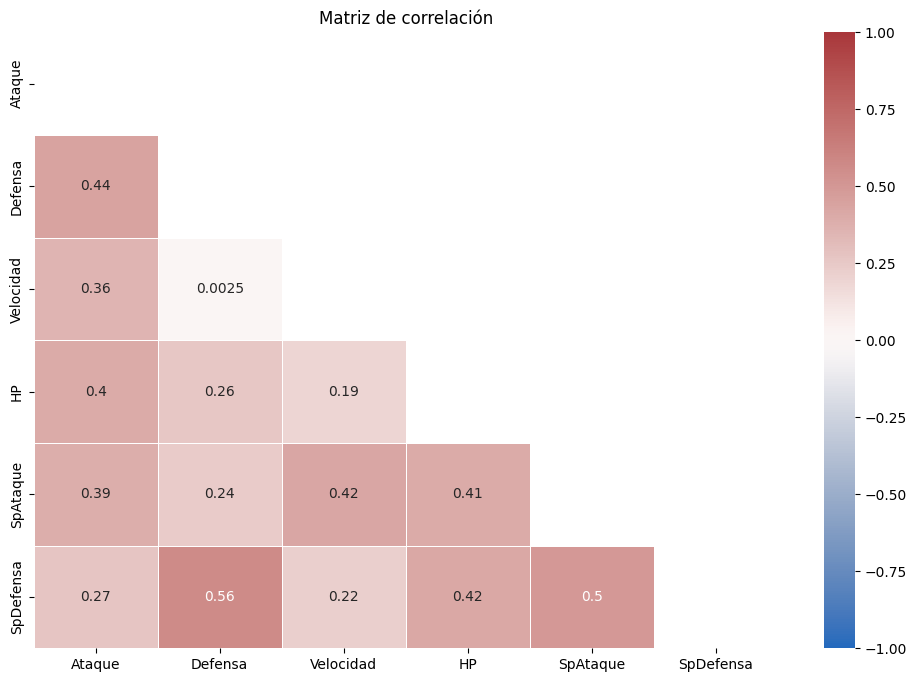

In [ ]:
# Calcular la matriz de correlación
corr_matrix = df_numeric.corr()

# Crear la máscara
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Crear el colormap
colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Graficar el heatmap de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()


Se puede observar poca correlación entre las variables.

¿Qué tan balanceado está nuestro dataset?

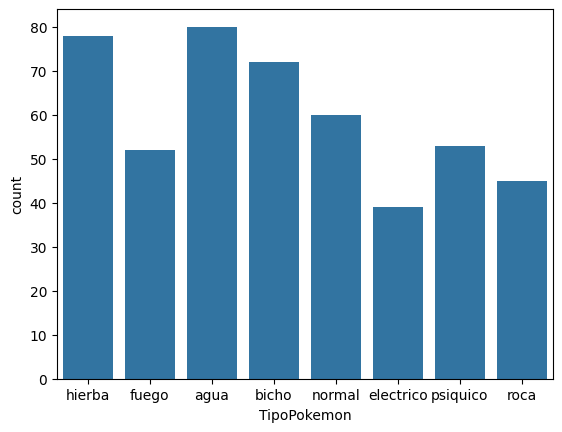

In [ ]:
sns.countplot(x='TipoPokemon', data=df_pokemon)
plt.show()

Podemos observar que nuestra variable objetivo presenta un desbalance en las clases. Por lo tanto, a continuación, procederemos a balancearlas para asegurar que el modelo se entrene adecuadamente sin inconvenientes.

## Balanceo de dataset

In [ ]:
# Separamos
X = df_pokemon.drop(['Nombre', 'TipoPokemon'], axis=1)
y = df_pokemon['TipoPokemon']

# Balanceamos el dataset utilizando oversampling
balanced_data = pd.concat([X, y], axis=1)
balanced_data_list = []

# Realizamos el sobremuestreo para cada clase
for class_label in y.unique():
    class_data = balanced_data[balanced_data['TipoPokemon'] == class_label]
    # Ampliar la muestra de las clases minoritarias para que coincidan con el recuento máximo de clases
    class_data_upsampled = resample(class_data,
                                    replace=True,
                                    n_samples=80, # para igualar el recuento de clases de 'agua', que es el maximo
                                    random_state=0)
    balanced_data_list.append(class_data_upsampled)

# Concatenar las clases balanceadas
balanced_data = pd.concat(balanced_data_list)

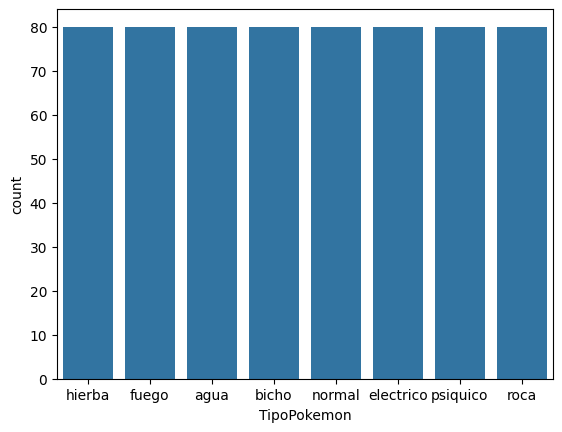

In [ ]:
sns.countplot(x='TipoPokemon', data=balanced_data)
plt.show()

Decidimos utilizar _oversampling_ porque su objetivo es incrementar la cantidad de la clase minoritaria, duplicando o generando nuevas muestras de esa clase hasta equilibrarla con la clase mayoritaria.

## Train-Test doble

In [ ]:
# Separamos la variable target
X = balanced_data.drop(columns=['TipoPokemon'])
y = balanced_data['TipoPokemon']

# Creamos el doble train-test
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=42)


## Arbol de decision para el conjunto 80-20

In [ ]:
# Convertir en arrays para el modelo
train_features_80 = np.array(X_train_80)
test_features_20 = np.array(X_test_20)
train_labels_80 = np.array(y_train_80)
test_labels_20 = np.array(y_test_20)
feature_list_80 = list(X_train_80.columns)

In [ ]:
# Inicializar y entrenar el modelo inicial en el conjunto 80-20
clf_initial = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2, criterion='gini', random_state=42)
clf_initial.fit(train_features_80, train_labels_80)

# Predicciones y evaluación en el conjunto de prueba (80-20) para el modelo inicial
predictions_test_20 = clf_initial.predict(test_features_20)


<ipython-input-94-8c3eee6a35b5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=features_df_sorted, x='importances', y='features', palette="rocket")


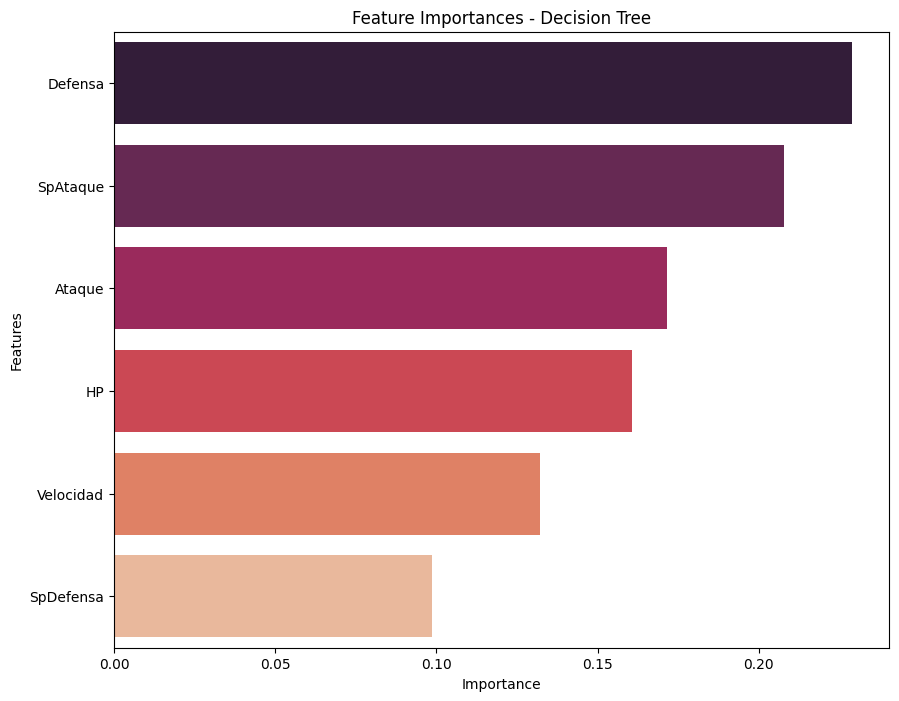

In [ ]:
# Importancia de características
features_df = pd.DataFrame({'features': feature_list_80, 'importances': clf_initial.feature_importances_})
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

# Gráfico de importancia de características
plt.figure(figsize=(10, 8))
sns.barplot(data=features_df_sorted, x='importances', y='features', palette="rocket")
plt.title('Feature Importances - Decision Tree')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

Se puede visualizar con gran facilidad cuales son las caracteristicas y sus importancias.

### Optimización de hiperparametros para train-test (80-20)

#### RandomizedSearchCV

In [ ]:
param_grid = {
    'max_features': range(1, 80),
    'max_depth': range(1, 80),
    'random_state': [18]
}
random_search = RandomizedSearchCV(tree.DecisionTreeClassifier(), param_grid, scoring='accuracy', cv=5, random_state=19)
random_search.fit(train_features_80, train_labels_80)

# Evaluación del mejor modelo de RandomizedSearchCV en el conjunto de prueba
best_random_model = random_search.best_estimator_
best_params = random_search.best_params_
best_predictions_random = best_random_model.predict(test_features_20)
print(f"Mejores parámetros (Randomized Search): {random_search.best_params_}")


Mejores parámetros (Randomized Search): {'random_state': 18, 'max_features': 38, 'max_depth': 73}


#### GridSearchCV

In [ ]:
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 15, 20, 21, 22],
    'min_samples_split': [2, 4, 5, 6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, scoring='accuracy', cv=5)
grid_search.fit(train_features_80, train_labels_80)

# Evaluación del mejor modelo de GridSearchCV en el conjunto de prueba
best_grid_model = grid_search.best_estimator_
best_predictions_grid = best_grid_model.predict(test_features_20)
print(f"Mejores parámetros (Grid Search): {grid_search.best_params_}")


Mejores parámetros (Grid Search): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


#### Comparación de los modelos

In [ ]:
# Comparación de resultados
print("Comparación de modelos:")
print("Modelo inicial:")
print(classification_report(test_labels_20, predictions_test_20))
print("Modelo RandomizedSearchCV:")
print(classification_report(test_labels_20, best_predictions_random))
print("Modelo GridSearchCV:")
print(classification_report(test_labels_20, best_predictions_grid))

Comparación de modelos:
Modelo inicial:
              precision    recall  f1-score   support

        agua       0.40      0.25      0.31        16
       bicho       0.59      0.56      0.57        18
   electrico       0.47      0.75      0.58        12
       fuego       0.67      0.75      0.71        16
      hierba       0.48      0.50      0.49        22
      normal       0.54      0.58      0.56        12
    psiquico       0.59      0.71      0.65        14
        roca       0.82      0.50      0.62        18

    accuracy                           0.56       128
   macro avg       0.57      0.58      0.56       128
weighted avg       0.57      0.56      0.56       128

Modelo RandomizedSearchCV:
              precision    recall  f1-score   support

        agua       0.67      0.50      0.57        16
       bicho       0.82      0.78      0.80        18
   electrico       0.85      0.92      0.88        12
       fuego       0.68      0.94      0.79        16
      hierb

El mejor modelo que obtuvimos fue con **RandomizedSearchCV**, ya que tiene el mayor *accuracy* y mejores *scores* en casi todas las métricas comparado con los otros dos modelos.
Por lo tanto vamos a realizarle la poda a ese modelo.

#### Poda

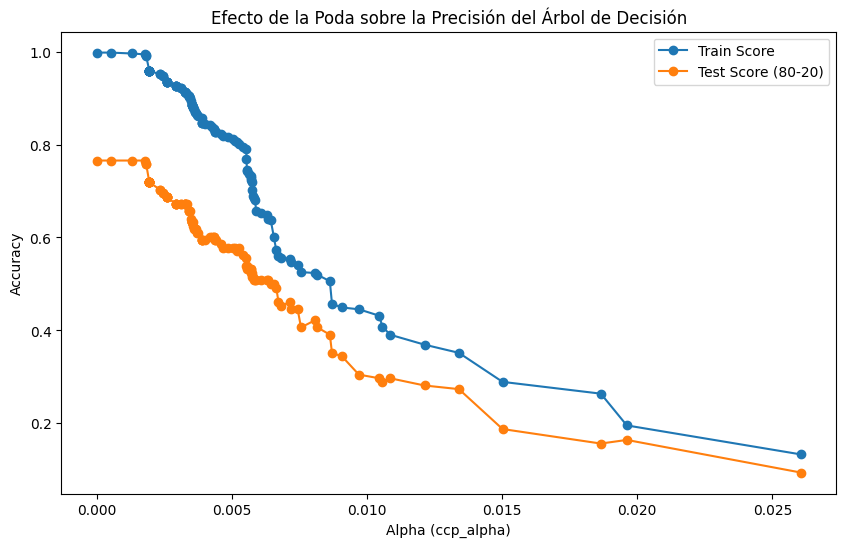

In [ ]:
# Realizamos la poda utilizando el camino de complejidad de costos
path = best_random_model.cost_complexity_pruning_path(train_features_80, train_labels_80)
ccp_alphas = path.ccp_alphas

# Entrenamos múltiples modelos variando ccp_alpha
clfs = []
for alpha in ccp_alphas:
    clf_poda = DecisionTreeClassifier(**best_params, ccp_alpha=alpha)
    clf_poda.fit(train_features_80, train_labels_80)
    clfs.append(clf_poda)

# Evaluamos precisión en entrenamiento y prueba para cada valor de ccp_alpha
train_scores = [clf.score(train_features_80, train_labels_80) for clf in clfs]
test_scores = [clf.score(test_features_20, test_labels_20) for clf in clfs]

# Graficamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, label="Train Score", marker='o')
plt.plot(ccp_alphas, test_scores, label="Test Score (80-20)", marker='o')
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Accuracy")
plt.title("Efecto de la Poda sobre la Precisión del Árbol de Decisión")
plt.legend()
plt.show()

En este gráfico, que muestra el efecto de la poda en un árbol de decisión ajustado con una división 80-20, se observan las siguientes tendencias:

1. **Disminución de Precisión con el Aumento de alpha**: A medida que incrementa el valor de alpha, tanto la precisión del conjunto de entrenamiento como la del conjunto de prueba disminuyen. Esto es consistente con el efecto de la poda, que simplifica el árbol y reduce su capacidad para ajustarse a los datos.

2. **Sobreajuste con Valores Bajos de alpha**: Cuando alpha es cercano a 0, la precisión en el conjunto de entrenamiento es muy alta (casi 1), indicando sobreajuste. Sin embargo, la precisión en el conjunto de prueba es notablemente menor, lo que indica que el modelo no generaliza bien en esos puntos.

3. **Estabilización de Precisión a Valores Altos de alpha**: A partir de un alpha cercano a 0.015, tanto la precisión de entrenamiento como la de prueba se estabilizan en valores bajos. Esto nos dice que el árbol se ha simplificado demasiado y está subajustado, lo cual reduce su capacidad para agarrar patrones de los datos.

4. **Rango Óptimo de alpha**: Alrededor de alpha entre 0.002 y 0.005, la precisión en el conjunto de prueba es relativamente alta, indicando un buen equilibrio entre complejidad y generalización.

El gráfico nos muestra cómo la poda reduce el sobreajuste, pero demasiada poda puede hacer que el modelo pierda precisión en general.

#### Gráficos de los árboles

##### Modelo inicial

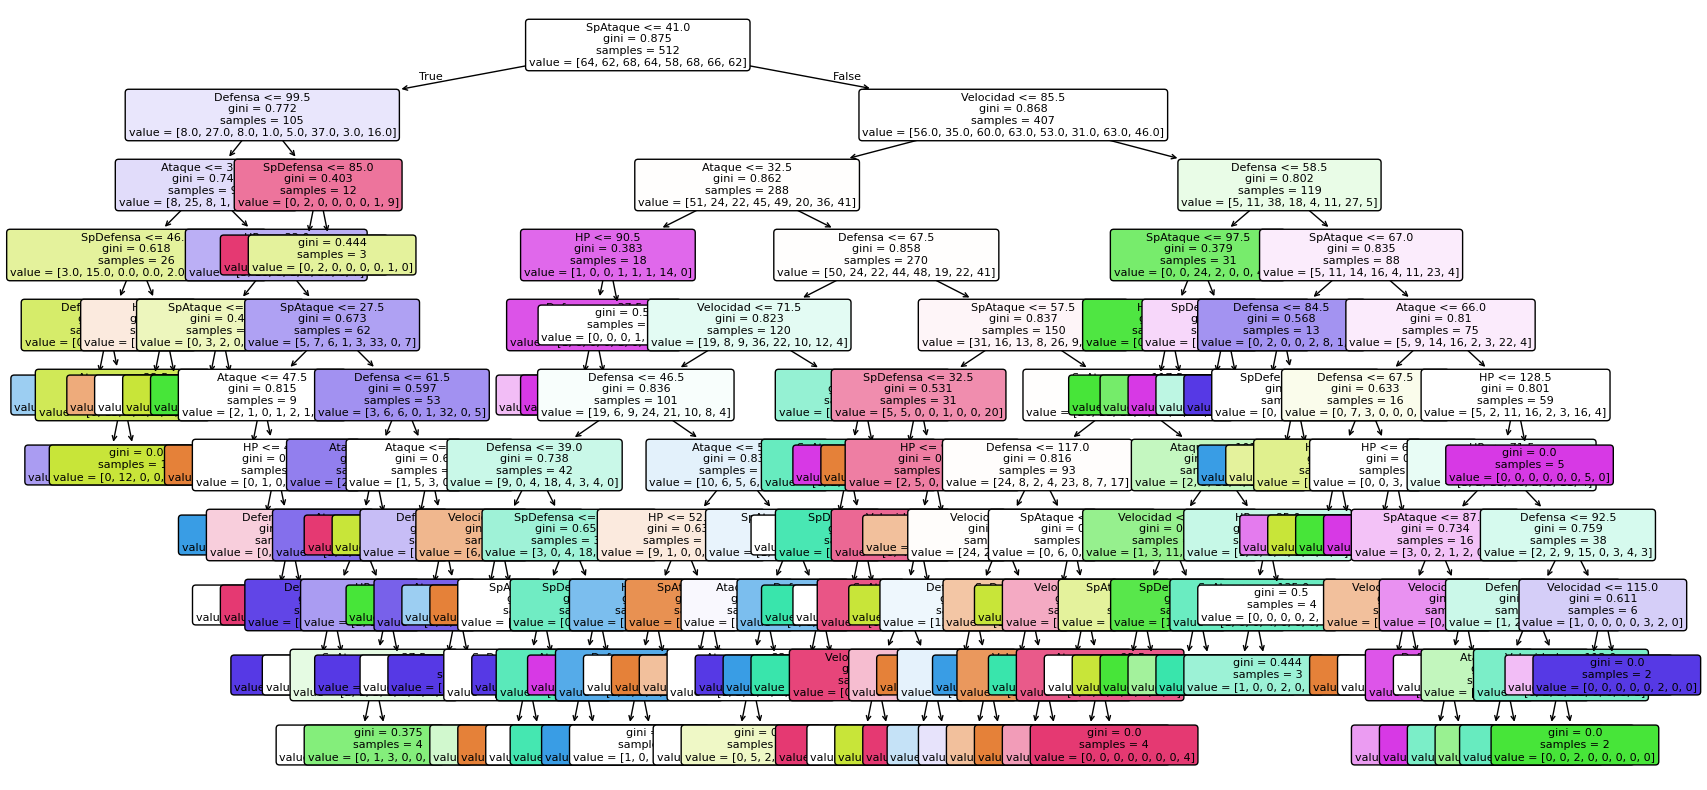

In [ ]:
# Graficar el árbol de decisión inicial entrenado en el conjunto 80-20
plt.figure(figsize=(20, 10))
plot_tree(clf_initial, feature_names=feature_list_80, fontsize=8, filled=True, rounded=True)
plt.show()

##### RandomizedSearch

###### Antes de la Poda.

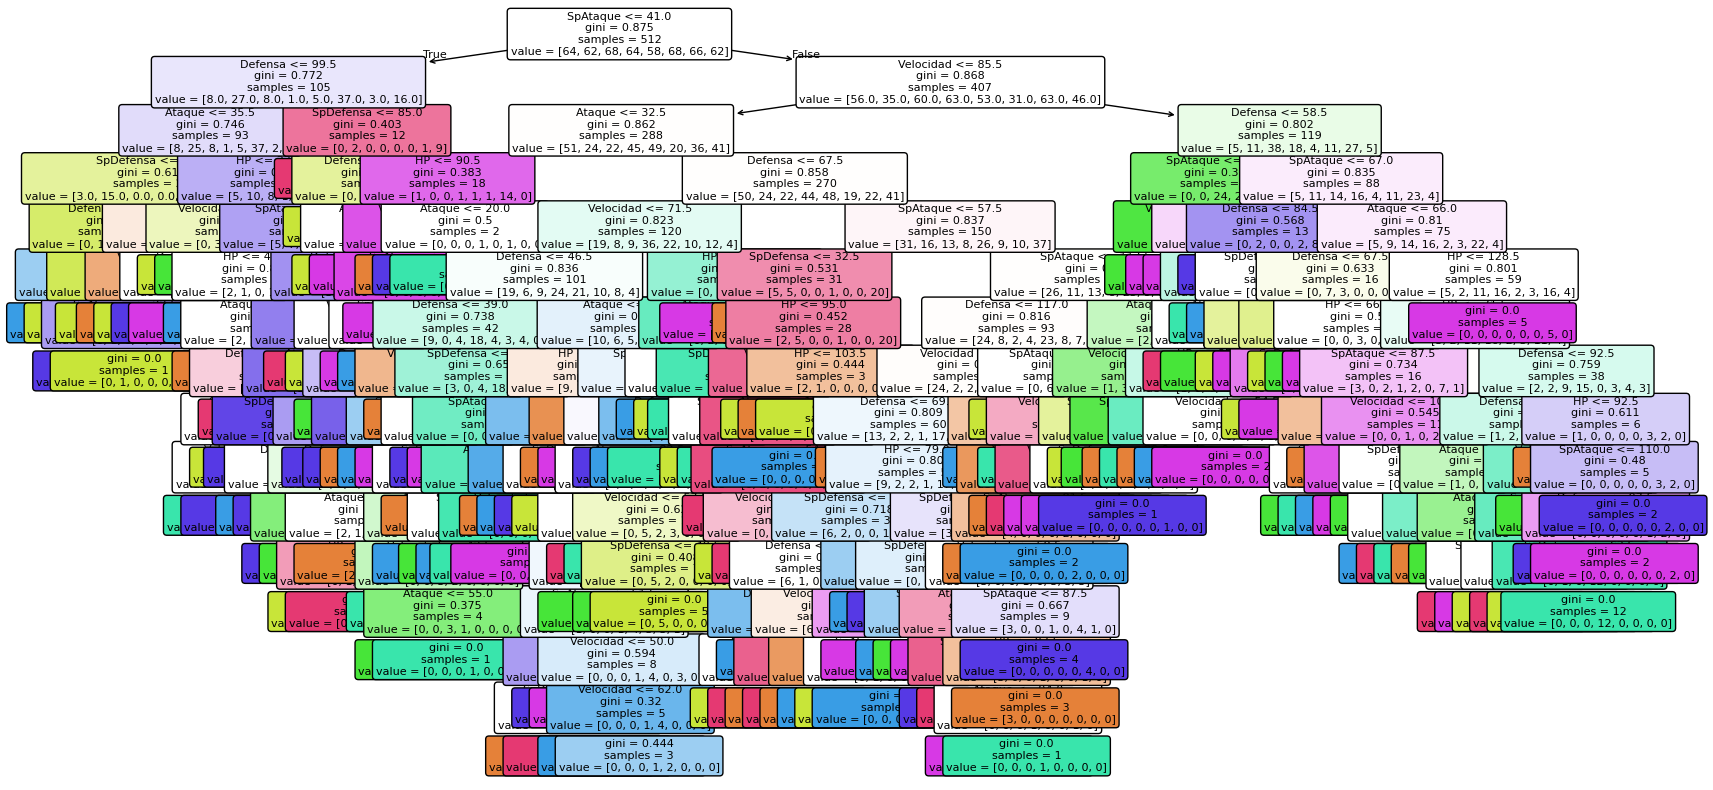

In [ ]:
# Extraer los mejores hiperparámetros del RandomizedSearch
best_params = random_search.best_params_

# Remover 'random_state' si está en los mejores parámetros para evitar conflicto
best_params.pop('random_state', None)

# Entrenar el modelo final con los mejores parámetros
best_clf = DecisionTreeClassifier(**best_params, random_state=42)
best_clf.fit(train_features_80, train_labels_80)

# Graficar el árbol de decisión con los mejores parámetros
plt.figure(figsize=(20, 10))
plot_tree(best_clf, feature_names=feature_list_80, fontsize=8, filled=True, rounded=True)
plt.show()


###### Despues de la Poda.

Para este caso, vimos que nuestro valor optimo de alpha se encuentra rondando los 0.0048, por lo tanto vamos a graficar en base a ese numero.

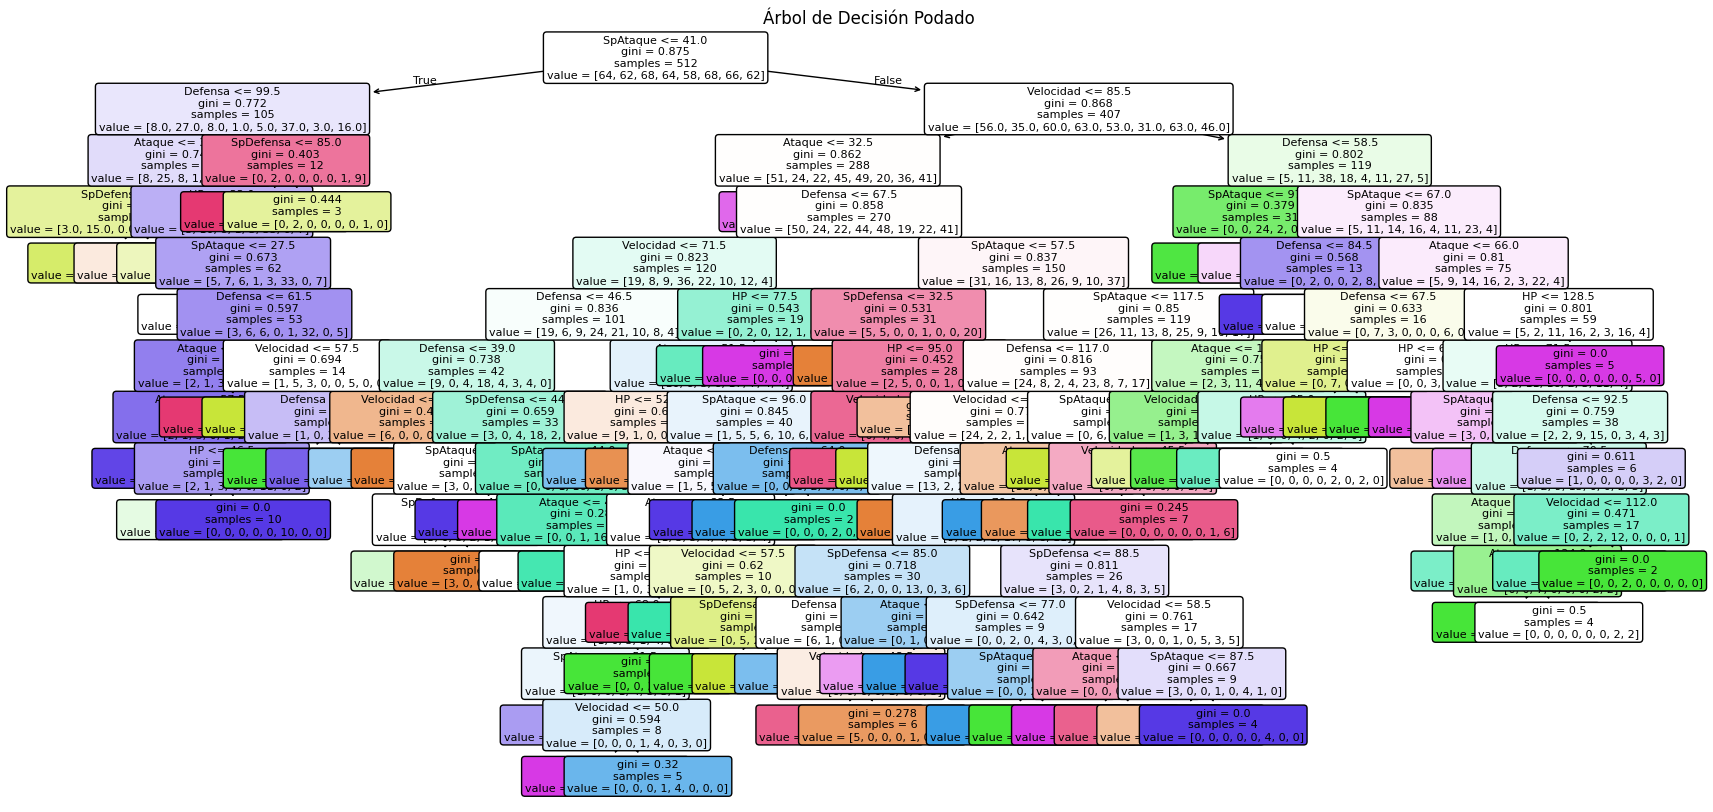

In [ ]:
optimal_ccp_alpha = 0.0048

# Entrenar el modelo podado con el mejor ccp_alpha
clf_podado = DecisionTreeClassifier(**best_params, random_state=42, ccp_alpha=optimal_ccp_alpha)
clf_podado.fit(train_features_80, train_labels_80)

# Predicciones con el modelo podado
best_predictions_podado = clf_podado.predict(test_features_20)

# Graficar el árbol de decisión podado
plt.figure(figsize=(20, 10))
plot_tree(clf_podado, feature_names=feature_list_80, fontsize=8, filled=True, rounded=True)
plt.title("Árbol de Decisión Podado")
plt.show()

Podemos ver como nuestro arbol se simplificó bastante realizando la Poda.

##### GridSearch.

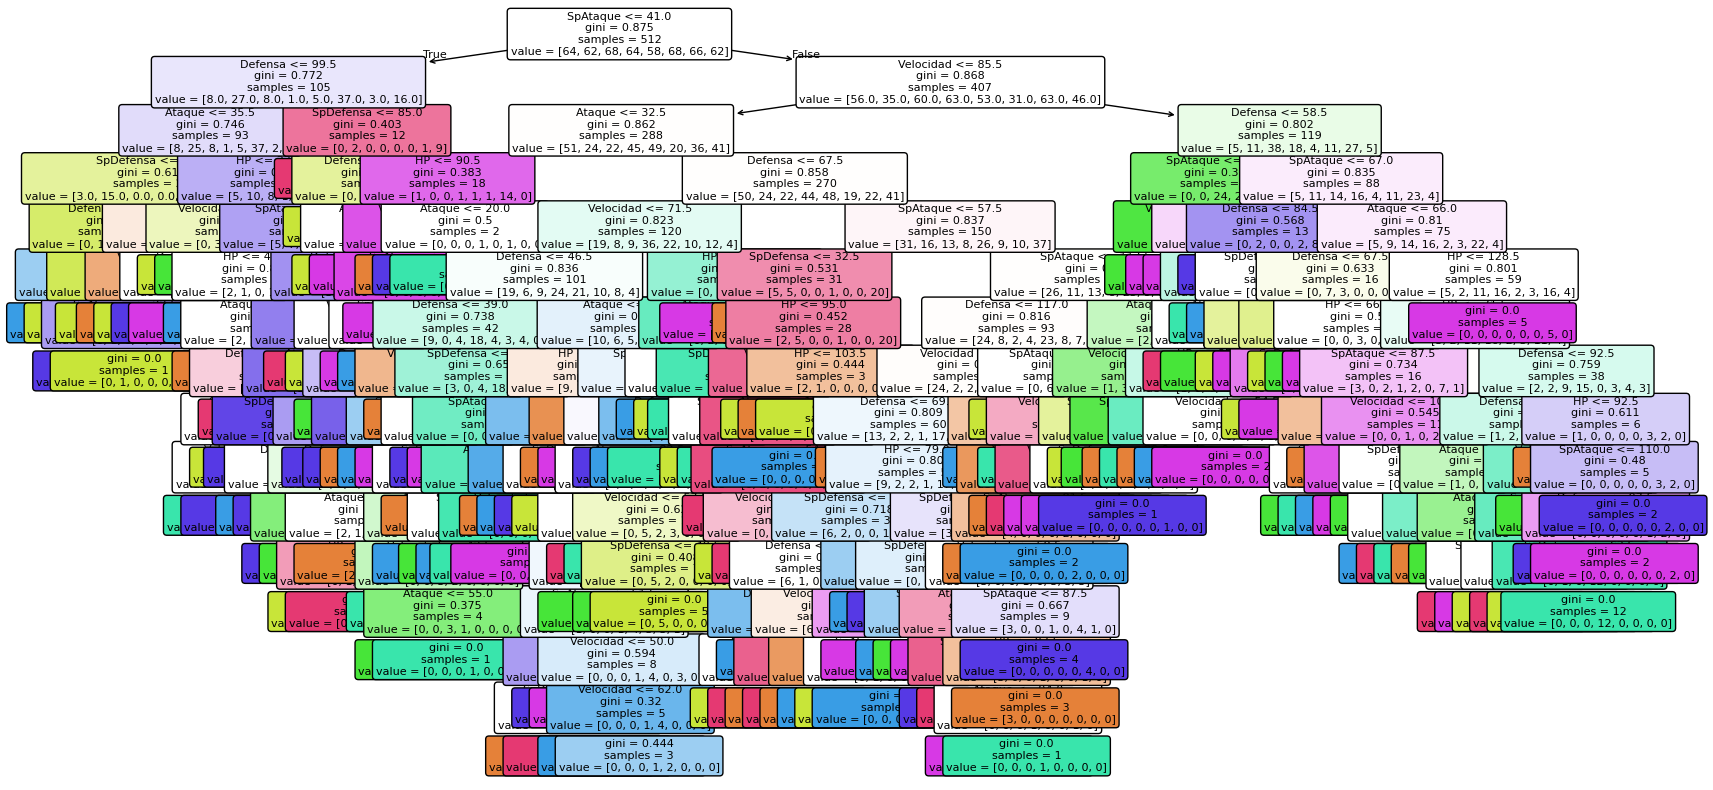

In [ ]:
# Extraer los mejores hiperparámetros del GridSearch
best_params = grid_search.best_params_

# Entrenar el modelo final con los mejores parámetros
best_clf = DecisionTreeClassifier(**best_params, random_state=42)
best_clf.fit(train_features_80, train_labels_80)

# Graficar el árbol de decisión con los mejores parámetros
plt.figure(figsize=(20, 10))
plot_tree(best_clf, feature_names=feature_list_80, fontsize=8, filled=True, rounded=True)
plt.show()

#### Comparación de las metricas antes y despues de la poda

In [ ]:
print("Modelo RandomizedearchCV sin Poda")
print(classification_report(test_labels_20, best_predictions_random))

print("Modelo RandomizedearchCV con Poda")
print(classification_report(test_labels_20, best_predictions_podado))

Modelo RandomizedearchCV sin Poda
              precision    recall  f1-score   support

        agua       0.67      0.50      0.57        16
       bicho       0.82      0.78      0.80        18
   electrico       0.85      0.92      0.88        12
       fuego       0.68      0.94      0.79        16
      hierba       0.82      0.64      0.72        22
      normal       0.82      0.75      0.78        12
    psiquico       0.80      0.86      0.83        14
        roca       0.71      0.83      0.77        18

    accuracy                           0.77       128
   macro avg       0.77      0.78      0.77       128
weighted avg       0.77      0.77      0.76       128

Modelo RandomizedearchCV con Poda
              precision    recall  f1-score   support

        agua       0.27      0.19      0.22        16
       bicho       0.56      0.50      0.53        18
   electrico       0.60      0.75      0.67        12
       fuego       0.61      0.69      0.65        16
      hier

- **Impacto Negativo de la Poda:** La poda, que generalmente se utiliza para simplificar el modelo y evitar el sobreajuste, en este caso parece haber llevado a un rendimiento inferior en las predicciones. Esto puede ser indicativo de que la poda excesiva ha reducido la capacidad del modelo para aprender patrones relevantes en los datos.


## Árbol de decision para conjunto 70-30

In [ ]:
train_features_70 = np.array(X_train_70)
test_features_30 = np.array(X_test_30)
train_labels_70 = np.array(y_train_70)
test_labels_30 = np.array(y_test_30)
feature_list_70 = list(X_train_70.columns)

In [ ]:
# Inicializar y entrenar modelo en el conjunto 70-30
clf_initial_70 = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2, criterion='gini', random_state=42)
clf_initial_70.fit(train_features_70, train_labels_70)

# Predicciones y evaluación en el conjunto de prueba (70-30)
predictions_test_30 = clf_initial_70.predict(test_features_30)

### Optimización de hiperparametros para train-test (70-30)

#### RandomizedSearchCV

In [ ]:
# Optimización con RandomizedSearchCV en conjunto 70-30
param_grid = {
    'max_features': range(1,60),
    'max_depth': range(1,60),
    'random_state': range(1,60)
}
random_search_70 = RandomizedSearchCV(tree.DecisionTreeClassifier(), param_grid, scoring='accuracy', cv=5, random_state=13)
random_search_70.fit(train_features_70, train_labels_70)

# Evaluación del mejor modelo de RandomizedSearchCV en el conjunto de prueba
best_random_model_70 = random_search_70.best_estimator_
best_predictions_random_70 = best_random_model_70.predict(test_features_30)
print(f"Mejores parámetros (Randomized Search): {random_search_70.best_params_}")


Mejores parámetros (Randomized Search): {'random_state': 23, 'max_features': 52, 'max_depth': 19}


#### GridSearchCV

In [ ]:
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 15, 20, 21, 22, 23, 24, 25, 26],
    'min_samples_split': [2, 4, 5, 6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}
grid_search_70 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, scoring='accuracy', cv=5)
grid_search_70.fit(train_features_70, train_labels_70)

# Evaluación del mejor modelo de GridSearchCV en el conjunto de prueba
best_grid_model_70 = grid_search_70.best_estimator_
best_params = grid_search_70.best_params_
best_predictions_grid_70 = best_grid_model_70.predict(test_features_30)
print(f"Mejores parámetros (Grid Search): {grid_search_70.best_params_}")


Mejores parámetros (Grid Search): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


#### Comparación de los modelos

In [ ]:
# Comparación de resultados
print("Comparación de modelos:")
print("Modelo inicial:")
print(classification_report(test_labels_30, predictions_test_30))
print("Modelo RandomizedSearchCV:")
print(classification_report(test_labels_30, best_predictions_random_70))
print("Modelo GridSearchCV:")
print(classification_report(test_labels_30, best_predictions_grid_70))

Comparación de modelos:
Modelo inicial:
              precision    recall  f1-score   support

        agua       0.29      0.35      0.31        23
       bicho       0.48      0.50      0.49        26
   electrico       0.64      0.72      0.68        25
       fuego       0.56      0.45      0.50        22
      hierba       0.39      0.42      0.41        31
      normal       0.47      0.43      0.45        21
    psiquico       0.71      0.56      0.62        18
        roca       0.56      0.54      0.55        26

    accuracy                           0.49       192
   macro avg       0.51      0.50      0.50       192
weighted avg       0.51      0.49      0.50       192

Modelo RandomizedSearchCV:
              precision    recall  f1-score   support

        agua       0.48      0.65      0.56        23
       bicho       0.59      0.65      0.62        26
   electrico       0.81      0.88      0.85        25
       fuego       0.81      0.59      0.68        22
      hierb

Tanto GridSearch como RandomizedSearch dan metricas muy similares, pero para este caso nos vamos a quedar con **GridSearch**.

### Poda

Por lo tanto nuestra poda la vamos a realizar para el modelo que mejor puntajes dio.

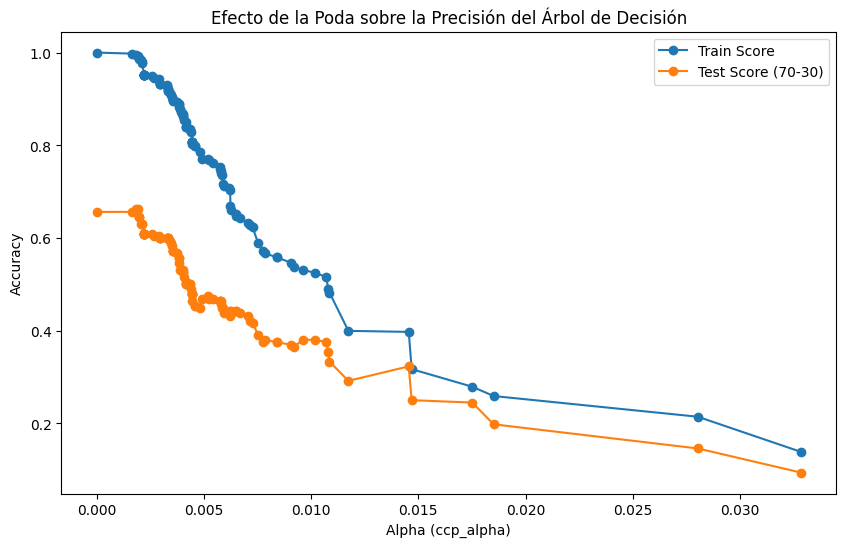

In [ ]:
# Realizamos la poda utilizando el camino de complejidad de costos
path_70 = best_grid_model_70.cost_complexity_pruning_path(train_features_70, train_labels_70)
ccp_alphas_70 = path_70.ccp_alphas

# Entrenamos múltiples modelos variando ccp_alpha
clfs = []
for alpha in ccp_alphas_70:
    clf_poda = DecisionTreeClassifier(**best_params, random_state=42, ccp_alpha=alpha)
    clf_poda.fit(train_features_70, train_labels_70)
    clfs.append(clf_poda)

# Evaluamos precisión en entrenamiento y prueba para cada valor de ccp_alpha
train_scores = [clf.score(train_features_70, train_labels_70) for clf in clfs]
test_scores = [clf.score(test_features_30, test_labels_30) for clf in clfs]

# Graficamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas_70, train_scores, label="Train Score", marker='o')
plt.plot(ccp_alphas_70, test_scores, label="Test Score (70-30)", marker='o')
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Accuracy")
plt.title("Efecto de la Poda sobre la Precisión del Árbol de Decisión")
plt.legend()
plt.show()


**Salto en Alpha ≈ 0.015**: Se observa un cambio abrupto en la precisión. Esto indica que el modelo pierde muchas ramas importantes, volviéndose demasiado simple (subajuste).

**Equilibrio entre Simplicidad y Precisión**: Entre alpha 0.003 y 0.005, el modelo parece encontrar un buen equilibrio, manteniendo una precisión razonable en el conjunto de prueba.

Al igual que el anterior gráfico, muestra cómo la poda reduce el sobreajuste, pero si es excesiva, hace que el modelo pierda precisión general.


#### Gráficos de los árboles

##### Modelo inicial

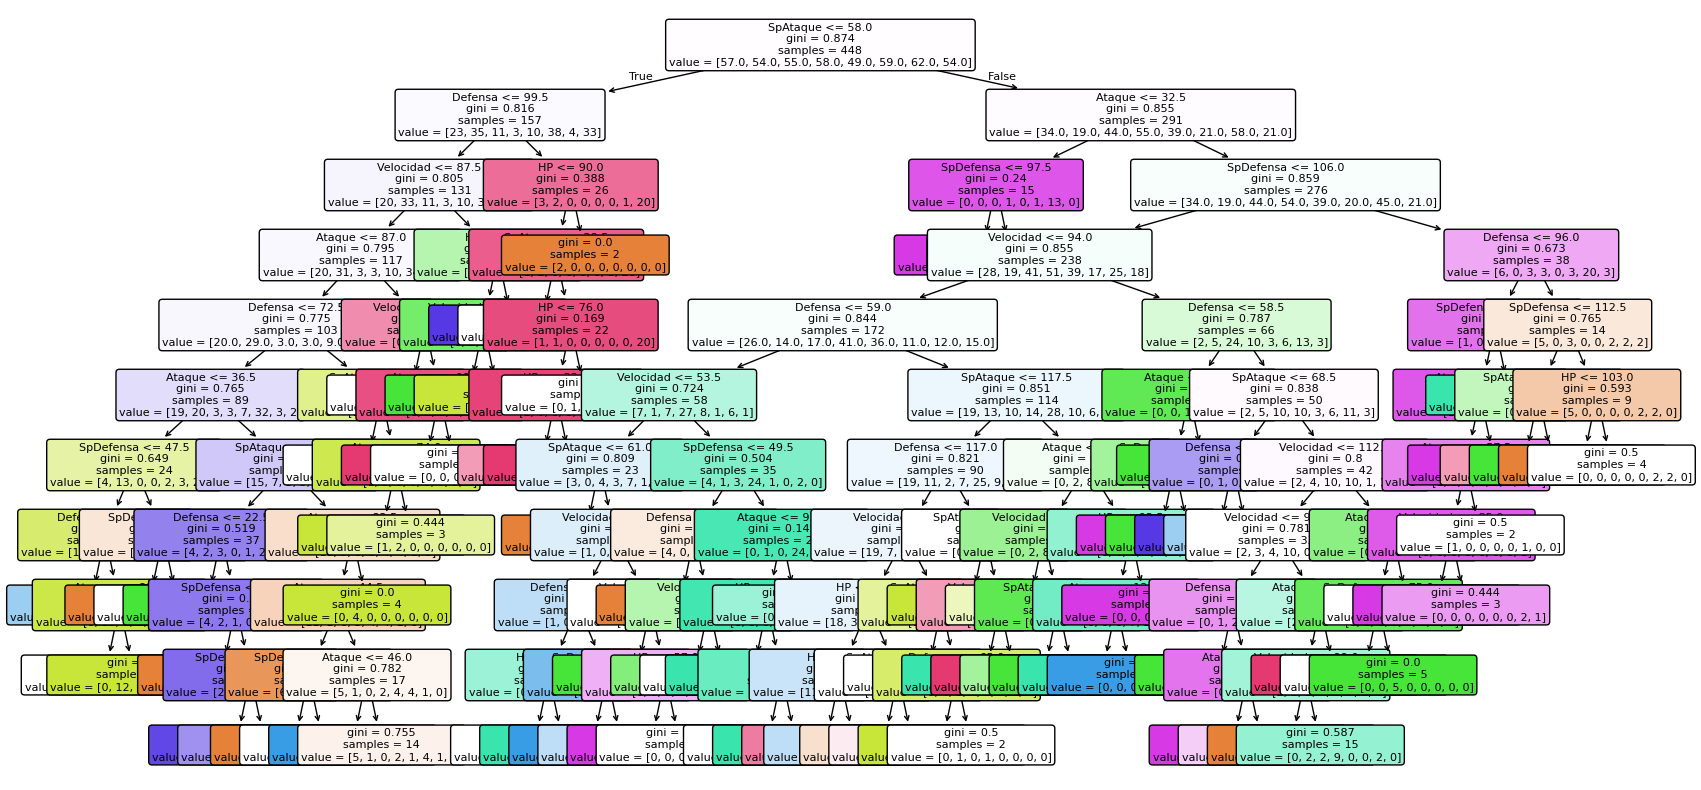

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(clf_initial_70, feature_names=feature_list_70, fontsize=8, filled=True, rounded=True)
plt.show()

##### RandomizedSearch

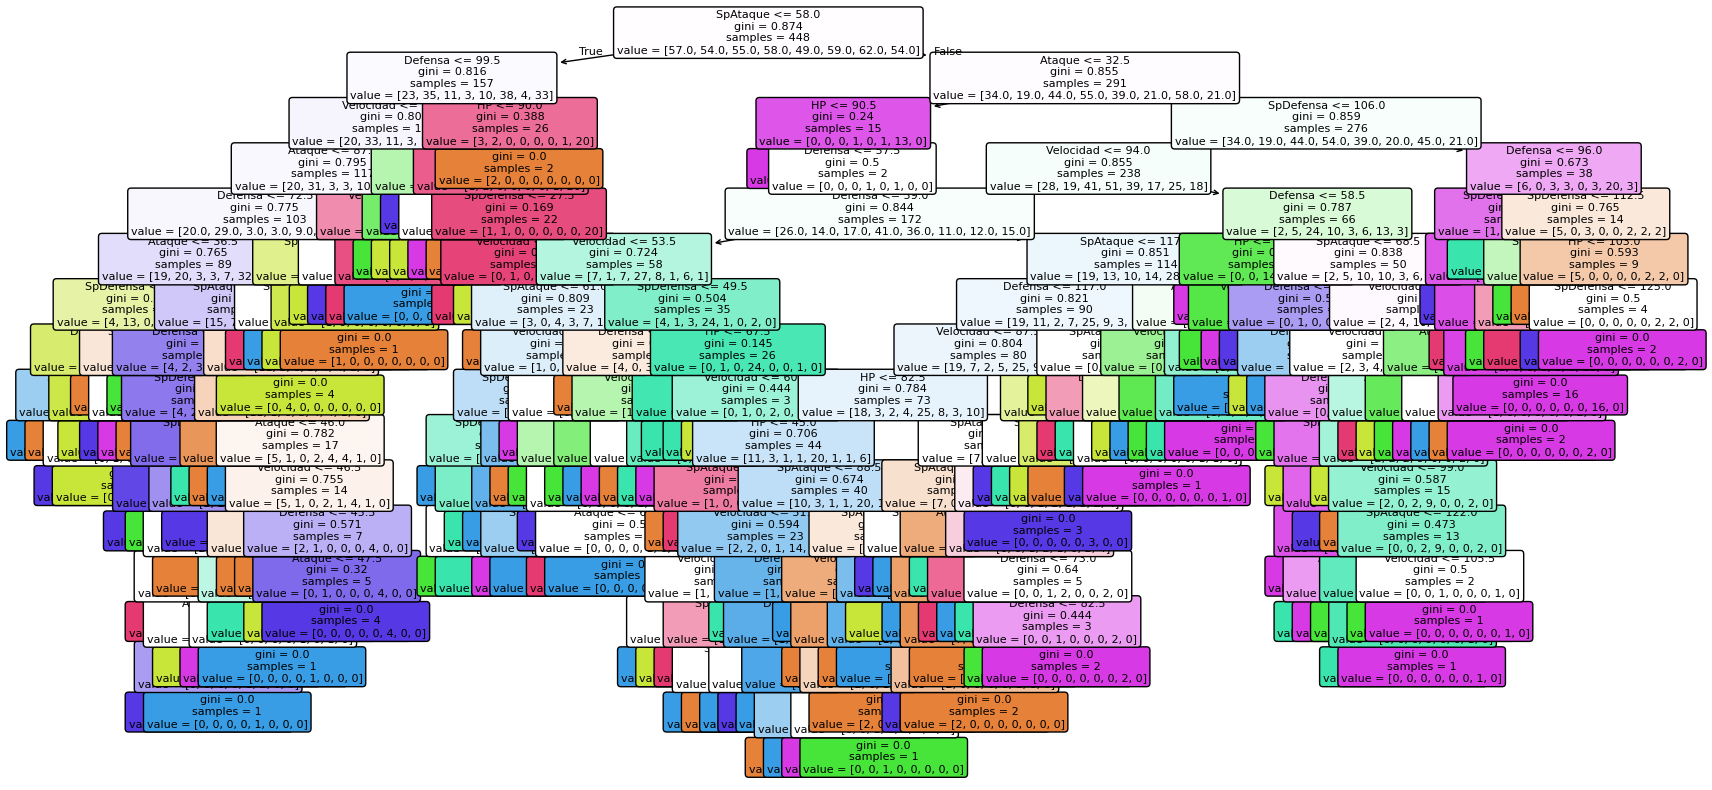

In [ ]:
# Extraer los mejores hiperparámetros del RandomizedSearch
best_params_70 = random_search_70.best_params_

# Remover 'random_state' si está en los mejores parámetros para evitar conflicto
best_params_70.pop('random_state', None)

# Entrenar el modelo final con los mejores parámetros
best_clf_70 = DecisionTreeClassifier(**best_params_70, random_state=42)
best_clf_70.fit(train_features_70, train_labels_70)

# Graficar el árbol de decisión con los mejores parámetros
plt.figure(figsize=(20, 10))
plot_tree(best_clf_70, feature_names=feature_list_70, fontsize=8, filled=True, rounded=True)
plt.show()


##### GridSearch

###### Antes de la Poda.

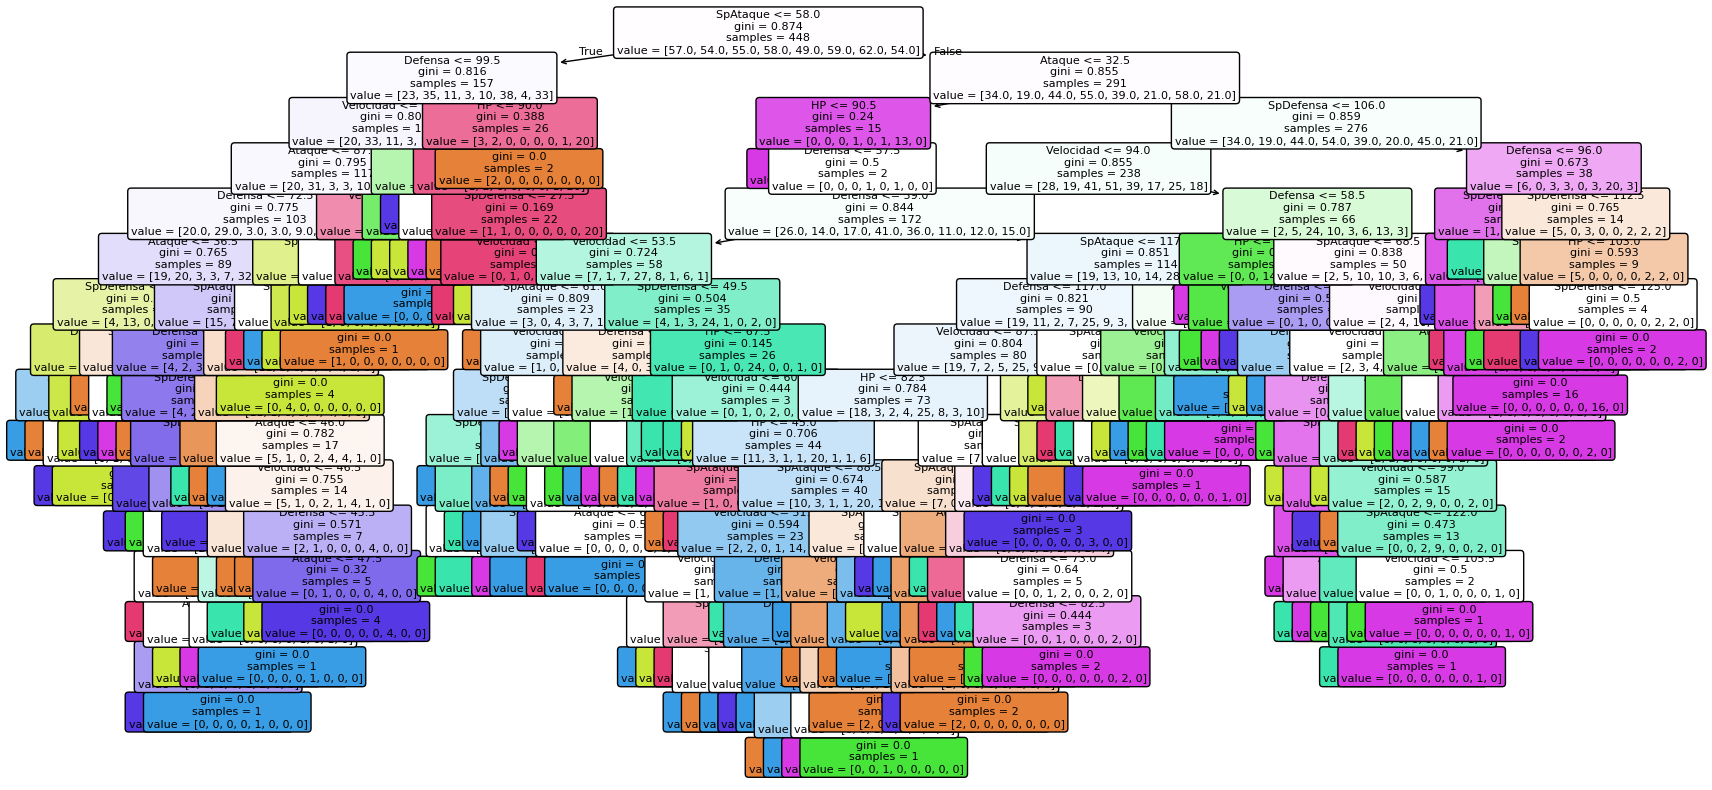

In [ ]:
# Extraer los mejores hiperparámetros del GridSearch
best_params_grid_70 = grid_search_70.best_params_

# Entrenar el modelo final con los mejores parámetros
best_clf_grid_70 = DecisionTreeClassifier(**best_params_grid_70, random_state=42)
best_clf_grid_70.fit(train_features_70, train_labels_70)

# Graficar el árbol de decisión con los mejores parámetros
plt.figure(figsize=(20, 10))
plot_tree(best_clf_grid_70, feature_names=feature_list_70, fontsize=8, filled=True, rounded=True)
plt.show()

###### Despues de la Poda.

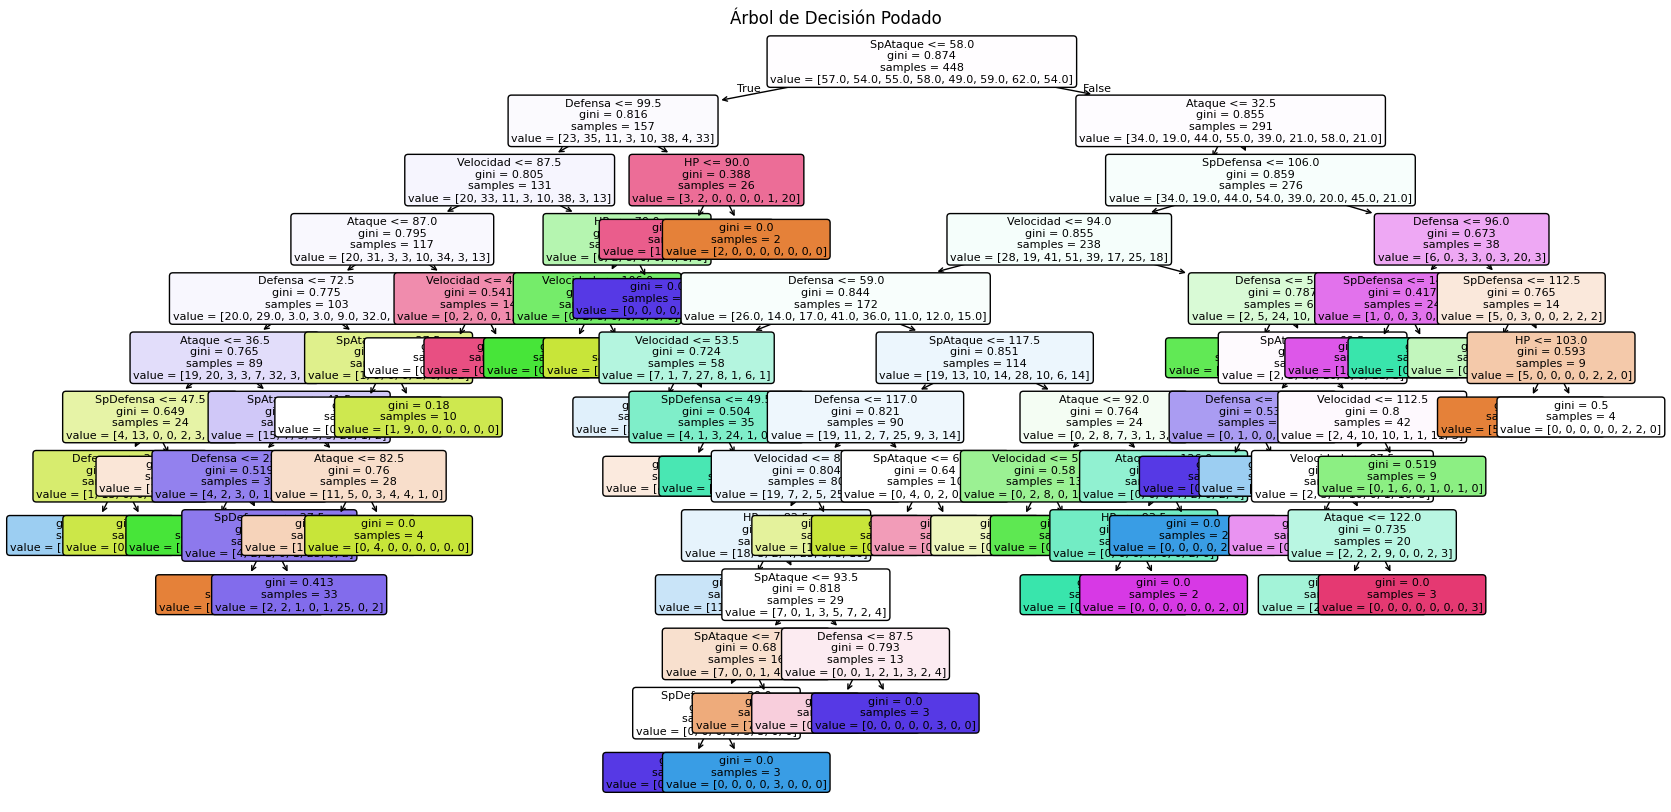

In [ ]:
optimal_ccp_alpha = 0.006

# Entrenar el modelo podado con el mejor ccp_alpha
clf_podado_70 = DecisionTreeClassifier(**best_params_grid_70, random_state=42, ccp_alpha=optimal_ccp_alpha)
clf_podado_70.fit(train_features_70, train_labels_70)

# Predicciones con el modelo podado
best_predictions_podado_70 = clf_podado_70.predict(test_features_30)

# Graficar el árbol de decisión podado
plt.figure(figsize=(20, 10))
plot_tree(clf_podado_70, feature_names=feature_list_70, fontsize=8, filled=True, rounded=True)
plt.title("Árbol de Decisión Podado")
plt.show()

#### Comparación de los modelos antes y despues de la Poda.

In [ ]:
print("Modelo GridSearchCV sin Poda")
print(classification_report(test_labels_30, best_predictions_grid_70))

print("Modelo GridSearchCV con Poda")
print(classification_report(test_labels_30, best_predictions_podado_70))

Modelo GridSearchCV sin Poda
              precision    recall  f1-score   support

        agua       0.52      0.65      0.58        23
       bicho       0.68      0.65      0.67        26
   electrico       0.77      0.92      0.84        25
       fuego       0.87      0.59      0.70        22
      hierba       0.62      0.42      0.50        31
      normal       0.67      0.67      0.67        21
    psiquico       0.50      0.72      0.59        18
        roca       0.72      0.69      0.71        26

    accuracy                           0.66       192
   macro avg       0.67      0.66      0.66       192
weighted avg       0.67      0.66      0.65       192

Modelo GridSearchCV con Poda
              precision    recall  f1-score   support

        agua       0.24      0.39      0.30        23
       bicho       0.48      0.42      0.45        26
   electrico       0.52      0.52      0.52        25
       fuego       0.43      0.27      0.33        22
      hierba       0

Para esta ocasión se observa exactamente lo mismo que el caso anterior. Al realizar la poda el modelo se vuelve peor.

## Bayes Ingenuos

In [ ]:
# Discretizar los atributos
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Aplicar la discretización a cada conjunto de datos
X_train_80_discretized = discretizer.fit_transform(X_train_80)
X_test_20_discretized = discretizer.transform(X_test_20)
X_train_70_discretized = discretizer.fit_transform(X_train_70)
X_test_30_discretized = discretizer.transform(X_test_30)

In [ ]:
# Entrenar y evaluar en la división 80-20
nb_80 = CategoricalNB()
nb_80.fit(X_train_80_discretized, y_train_80)
y_pred_80 = nb_80.predict(X_test_20_discretized)

accuracy_80 = accuracy_score(y_test_20, y_pred_80)
recall_80 = recall_score(y_test_20, y_pred_80, average='weighted')
precision_80 = precision_score(y_test_20, y_pred_80, average='weighted')


# Entrenar y evaluar en la división 70-30
nb_70 = CategoricalNB()
nb_70.fit(X_train_70_discretized, y_train_70)
y_pred_70 = nb_70.predict(X_test_30_discretized)

accuracy_70 = accuracy_score(y_test_30, y_pred_70)
recall_70 = recall_score(y_test_30, y_pred_70, average='weighted')
precision_70 = precision_score(y_test_30, y_pred_70, average='weighted')

In [ ]:
print("Resultados en el conjunto 80-20 (con discretización):")
print(f"Precisión (Accuracy): {accuracy_80:.2f}")
print(f"Exhaustividad (Recall): {recall_80:.2f}")
print(f"Exactitud (Precision): {precision_80:.2f}")

print("\nResultados en el conjunto 70-30 (con discretización):")
print(f"Precisión (Accuracy): {accuracy_70:.2f}")
print(f"Exhaustividad (Recall): {recall_70:.2f}")
print(f"Exactitud (Precision): {precision_70:.2f}")

Resultados en el conjunto 80-20 (con discretización):
Precisión (Accuracy): 0.36
Exhaustividad (Recall): 0.36
Exactitud (Precision): 0.40

Resultados en el conjunto 70-30 (con discretización):
Precisión (Accuracy): 0.32
Exhaustividad (Recall): 0.32
Exactitud (Precision): 0.33


### Análisis General
- **Bajo Rendimiento**: Los resultados en ambos conjuntos son bastante bajos, lo que nos dice que el modelo Naive Bayes puede no ser el más adecuado para este problema o que la discretización aplicada a las características no captura adecuadamente la información relevante para clasificar a los Pokémon.

Antes de llegar a esta configuración, probamos distintas discretizaciones, pero los resultados obtenidos eran inferiores a los actuales, por lo que decidimos mantener la discretización utilizada.


## k-NN

In [ ]:
scaler = StandardScaler()
X_train_80_scaled = scaler.fit_transform(X_train_80)
X_test_20_scaled = scaler.transform(X_test_20)
X_train_70_scaled = scaler.fit_transform(X_train_70)
X_test_30_scaled = scaler.transform(X_test_30)

In [ ]:
# Definimos el rango de vecinos, métricas y valores de p
param_grid = {
    'n_neighbors': range(1, 21),  # Ahora de 1 a 20 vecinos
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'p': [1, 2, 3]  # Incluyendo un valor de p=3 para minkowski
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid, scoring='accuracy', cv=5)


In [ ]:
# Para el conjunto de entrenamiento al 80%
grid_search_knn.fit(X_train_80_scaled, y_train_80)
best_params_80 = grid_search_knn.best_params_

# Para el conjunto de entrenamiento al 70%
grid_search_knn.fit(X_train_70_scaled, y_train_70)
best_params_70 = grid_search_knn.best_params_


In [ ]:
# Evaluación en el conjunto de prueba 20%
knn_80 = KNeighborsClassifier(**best_params_80)
knn_80.fit(X_train_80_scaled, y_train_80)
y_pred_20 = knn_80.predict(X_test_20_scaled)

accuracy_20 = accuracy_score(y_test_20, y_pred_20)
precision_20 = precision_score(y_test_20, y_pred_20, average='weighted')
recall_20 = recall_score(y_test_20, y_pred_20, average='weighted')

# Evaluación en el conjunto de prueba 30%
knn_70 = KNeighborsClassifier(**best_params_70)
knn_70.fit(X_train_70_scaled, y_train_70)
y_pred_30 = knn_70.predict(X_test_30_scaled)

accuracy_30 = accuracy_score(y_test_30, y_pred_30)
precision_30 = precision_score(y_test_30, y_pred_30, average='weighted')
recall_30 = recall_score(y_test_30, y_pred_30, average='weighted')


In [ ]:
print("\nResultados en el conjunto 80-20:")
print(f"Precisión (Accuracy): {accuracy_20:.2f}")
print(f"Exhaustividad (Recall): {recall_20:.2f}")
print(f"Exactitud (Precision): {precision_20:.2f}")

print("\nResultados en el conjunto 70-30:")
print(f"Precisión (Accuracy): {accuracy_30:.2f}")
print(f"Exhaustividad (Recall): {recall_30:.2f}")
print(f"Exactitud (Precision): {precision_30:.2f}")



Resultados en el conjunto 80-20:
Precisión (Accuracy): 0.77
Exhaustividad (Recall): 0.77
Exactitud (Precision): 0.78

Resultados en el conjunto 70-30:
Precisión (Accuracy): 0.71
Exhaustividad (Recall): 0.71
Exactitud (Precision): 0.72


### Análisis

1. **Conjunto 80-20:**
   - **Rendimiento Sólido:** La precisión, el recall y la exactitud son bastante equilibrados y están en un nivel aceptable (77-78%). Esto indica que el modelo K-NN está tomando bien la relación entre las características y las etiquetas en este conjunto de datos.

2. **Conjunto 70-30:**
   - **Rendimiento Inferior:** La precisión, el recall y la exactitud son más bajos (71-72%) en comparación con el conjunto 80-20. Esto podría decirnos que el modelo K-NN tiene más dificultad para generalizar cuando se entrena con menos datos.
